In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import scanpy as sc
import matplotlib.gridspec as gridspec
import pickle
 

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#%matplotlib inline
sc.settings.figdir = "fig2"
sc.settings.set_figure_params(dpi_save=300, facecolor="white", frameon=False, figsize=(25,25))


# Load data

In [3]:
FILE_NAME = "adata_combined_new.h5ad.final.filtered"
PATH2=f'/nfs/team298/ls34/adult_skin/final_adatas/{FILE_NAME}'
adata_5k=sc.read_h5ad(PATH2)
adata_5k=adata_5k[adata_5k.obs["tech"]=="xenium"].copy()

def remove_markers(LIST):
    try: 
        LIST = {key: [gene for gene in genes if gene in adata_5k.var_names] 
                           for key, genes in LIST.items()}
    except: 
        LIST =[gene for gene in LIST if gene in adata_5k.var_names]
    return LIST


 


# Remove niche where skin folded 

In [4]:
adata_5k=adata_5k[adata_5k.obs["niche19"]!= 'Nonspecific/folded'].copy()
NICHE = "niche19"
CATEGORY="lvl5_annotation"

# Compare niches for healthy vs non-lesional

In [5]:
adata_5k_i = adata_5k[          (adata_5k.obs["Timepoint"].str.startswith("Past"))|
                    (adata_5k.obs["disease_overall"].str.startswith("Healthy"))|

                    (adata_5k.obs["Site_status"].str.startswith("Healthy"))|
                                            (adata_5k.obs["Site_status"].str.startswith("Base"))|
                                                      (adata_5k.obs["Site_status"].str.startswith("Never"))|
                           (adata_5k.obs["Site_status"].str.startswith("Non"))|
     (adata_5k.obs["Site_status"].str.startswith("Psoriasis_replicate_non-lesional"))
   
      # (adata_5k.obs["Site_status"]=="Healthy")
                   ]
adata_5k_i.obs["Site_status"].value_counts()

Site_status
Non-lesional                        365833
Psoriasis_replicate_non-lesional     76048
Healthy                              59315
Name: count, dtype: int64

In [6]:
path = "/nfs/team298/ls34/niche_colors.pkl"
with open(path, "rb") as f:
    colors_new2 = pickle.load(f)



/tmp/ipykernel_2927642/409184.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["disease_overall", "niche19"])
/tmp/ipykernel_2927642/409184.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = counts.groupby("disease_overall")["count"].sum().reset_index(name="total")
/tmp/ipykernel_2927642/409184.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  plot_df = counts.pivot_table(


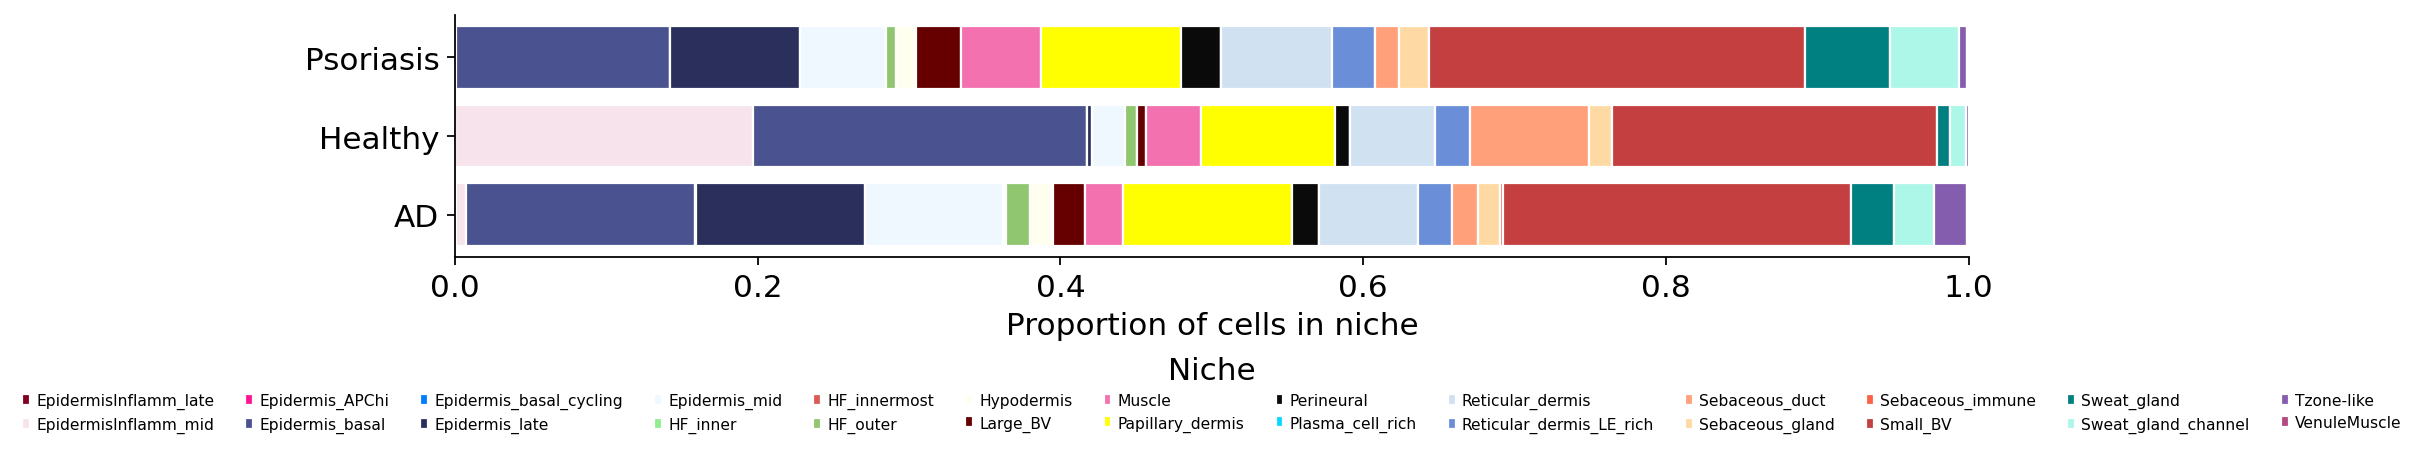

In [7]:
df = adata_5k_i.obs[["disease_overall", "niche19"]].copy()

counts = (
    df.groupby(["disease_overall", "niche19"])
      .size()
      .reset_index(name="count")
)



total_counts = counts.groupby("disease_overall")["count"].sum().reset_index(name="total")
counts = counts.merge(total_counts, on="disease_overall")
counts["prop"] = counts["count"] / counts["total"]

niche_order = counts["niche19"].unique()

plot_df = counts.pivot_table(
    index="disease_overall",
    columns="niche19",
    values="prop",
    fill_value=0
)[niche_order].reset_index()

fig, ax = plt.subplots(figsize=(14, 3.5))  # Increased height slightly for space below

x_offsets = np.zeros(len(plot_df))
fallback = "#d3d3d3"
colors = [colors_new2.get(n, fallback) for n in niche_order]

for i, niche in enumerate(niche_order):
    props = plot_df[niche].values
    ax.barh(
        y=plot_df["disease_overall"],
        width=props,
        left=x_offsets,
        color=colors[i],
        edgecolor="white",
        label=niche
    )
    x_offsets += props

ax.set_xlabel("Proportion of cells in niche")
ax.set_xlim(0, 1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)
ax.set_title("")

n_cols = int(np.ceil(len(niche_order) / 2))
ax.legend(
    bbox_to_anchor=(0.5, -0.35),  # Below plot
    loc="upper center",
    ncol=n_cols,
    fontsize=7,
    title="Niche",
    frameon=False
)

plt.tight_layout()
plt.show()

# Nonlesional cell contents

In [8]:
adata_5k_i.obs.Site_status_binary.value_counts()
adata_5k_i=adata_5k[(adata_5k.obs["Site_status"]=="Non-lesional")|
                 (adata_5k.obs["Site_status"].str.startswith("Psoriasis_replicate_non-lesional"))
                   ]


In [9]:
adata_5k_i = adata_5k_i[(adata_5k_i.obs["lvl0"].str.startswith("T"))|
                     (adata_5k_i.obs[CATEGORY].str.startswith("Plasm"))|
                        (adata_5k_i.obs[CATEGORY].str.startswith("Bcell"))|
                     (adata_5k_i.obs["lvl0"]=="Myeloid")|
                         (adata_5k_i.obs[CATEGORY]=="Mast cell") |
                      (adata_5k_i.obs[CATEGORY]=="LC_ALOX15hi") 
                      

               ]
adata_5k_i.shape

desired_order2 =  ['Treg','Treg_LRRC32','Treg_LRRC32+', 'TR1', 'Tnaive','Tnaive1','Tnaive2', 'Tnaive/T_cm', 'Tnaive/Tcm', 'T_polarized_CCR6+','Th', 
                  'Th_PPARGhi',
                  'Th_PPARGhi_IL17+',
                  'Tc',
                 'Tc_IFNGhi',"Tc_ZNF683+",'T_γδ',
            'Tc_IL13','TRM_IL13',"TRM_IL13+",
'TRM_IL17', "TRM_IL17+",'Th/TRM prolif', 'T','T_polarized',
                
                 







                
                 'T_Prolif','T_prolif','Treg/Tnaive_prolif',

'NK', "ILC1/NK","ILC_prolif",
                 
'ILC_Prolif',
          

'ILC1','ILC1_NCR2+P2RX7+','ILC3',
                  'ILC3_CCL1+PTGDS+', 
                  
                          'ILC2',
                  
                  
                'Plasma cell',
                  "Monocyte",
                  'Monocyte?', 'Mac',
                   
                   
                   
                   
                   'Macint','Mac_TREM2+LPL+',
                   
                   
                'Mac1',  'Mac2',


'Tc0','Tc1','Tc2','Tc3_IFNGhi',

                   'Tc_Prolif' ,




 'Mac2_CCL14hi','Mac_CCL14hi','MacCCL14_hi','Mac_LPLhi', 'Mac LPLhi (P2RY12-)',
                  'Mac LPLhi','Mac_TREM+','Mac_Perineural?',"Mac_CX3CR1+",
                  'Mac_prolif/PreDC', 'TransitionalDC',
                   "Mac_prolif/preDC",
'Mac_prolif',
















'cDC',
 'cDC1',
 'cDC2', 'cDC2_MMP12',   'cDC2: MMP12+', 'cDC2: MMP12hi', "cDC2: MMP12+IL1B+",'cDC2: THBS1+', 'cDC2: EREG+CCR7+', 'cDC2_cycling',
                  'MoDC/cDC2','MoDC','cDC2_MoDC(C1QTNF1+KDR+)','cDC2_MoDC (THBS1+)', 'cDC2_THBS1+','LC/MoDC_MMP12+/CXCL9+',
                  'cMoDC/cDC (C1QTNF1+KDR+)','MoDC?','MoDC_lowqithink?',

                   'LC_CCR7+','LC_SLC18A2+',
 'LC','LC_ALOX15hi',
'cDC2_MMP12hi (Mig)','cDC: MMP12+/CXCL9+', 
 'MigDC','MigDC_T_doublet',
                  'MigDC (cDC1)','MigDC (cDC2)',
 'pDC',"Mast cell", "Neutrophil",
                 
                  'DC2/Mac',
                  "Bcell",



 

]


# Ensure 'lvl3_annotation' is categorical
if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
    adata_5k_i.obs[CATEGORY] = adata_5k_i.obs[CATEGORY].astype('category')

    
if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
    adata_5k_i.obs[CATEGORY] = adata_5k_i.obs[CATEGORY].astype('category')

missing_data = 0
for x in list(adata_5k_i.obs[CATEGORY].unique()):
    if x not in desired_order2:
        print(x)
        missing_data +=1
if missing_data != 0:
    stop
        
        
# Set the categories in the desired order
adata_5k_i.obs[CATEGORY] = pd.Categorical(
    adata_5k_i.obs[CATEGORY],
    categories=desired_order2,
    ordered=True
)
 
    




/tmp/ipykernel_2927642/3620186754.py:107: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
/tmp/ipykernel_2927642/3620186754.py:111: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
/tmp/ipykernel_2927642/3620186754.py:124: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_5k_i.obs[CATEGORY] = pd.Categorical(


In [10]:
all_cell_types = sorted(adata_5k_i.obs["lvl5_annotation"].unique().tolist())
all_cell_types
for x in sorted(adata_5k_i.obs[CATEGORY].unique().tolist()):
    if x not in desired_order2:
        print(x)

In [11]:
mpl.rcParams["axes.grid"] = False  

In [12]:
desired_order = [ #'Epidermis_APChi', 
    'Epidermis_late', 
    #'EpidermisInflamm_mid',
    
    'Epidermis_mid', 'Epidermis_basal',
# 'EpidermisInflamm_late', 'EpidermisInflamm_mid', 'Epidermis_basal_cycling',

    
 'Papillary_dermis',
         'Small_BV',
                  'Tzone-like',
 'Reticular_dermis', #'Reticular_dermis_LErich',
                  'Reticular_dermis_LE_rich',

#'Plasma_cell_niche',

                  'Large_BV', 'VenuleMuscle',
                  'Perineural',
                #  'HF',
               #  'OuterHF',
    'HF_outer', 'HF_inner', #'HF_innermost',
 'Muscle',
 'Sebaceous_gland', 'Sebaceous_duct', #'Sebaceous_immune', 'Plasma_cell_rich',




                  'Sweat_gland',
 'Sweat_gland_channel',



# 'Sebaceous_immune',
# 'Epidermis_APChi',
                                   'Hypodermis',

 #'Perifollicular_VE',
 #'Epidermis_basal_immune'
                ]


for x in adata_5k_i.obs[NICHE].unique():
    if x not in desired_order:
        print(x)
desired_order2 = [x for x in desired_order if x in adata_5k_i.obs[NICHE] .unique()]

EpidermisInflamm_mid
Plasma_cell_rich
EpidermisInflamm_late
Epidermis_basal_cycling
Epidermis_APChi
Sebaceous_immune


In [13]:
desired_order = [ #'Epidermis_APChi', 
    'Epidermis_late', 
    #'EpidermisInflamm_mid',
    
    'Epidermis_mid', 'Epidermis_basal',
# 'EpidermisInflamm_late', 'EpidermisInflamm_mid', 'Epidermis_basal_cycling',

    
 'Papillary_dermis',
     'Reticular_dermis', #'Reticular_dermis_LErich',
                  'Reticular_dermis_LE_rich',
  
                  'Tzone-like',


#'Plasma_cell_niche',
       'Small_BV',
                  'Large_BV', 'VenuleMuscle',
                  'Perineural',
                #  'HF',
               #  'OuterHF',
    'HF_outer', 'HF_inner', #'HF_innermost',
 'Muscle',
 'Sebaceous_gland', 'Sebaceous_duct', #'Sebaceous_immune', 'Plasma_cell_rich',




                  'Sweat_gland',
 'Sweat_gland_channel',



# 'Sebaceous_immune',
# 'Epidermis_APChi',
                                   'Hypodermis',

 #'Perifollicular_VE',
 #'Epidermis_basal_immune'
                ]


for x in adata_5k_i.obs[NICHE].unique():
    if x not in desired_order:
        print(x)
desired_order2 = [x for x in desired_order if x in adata_5k_i.obs[NICHE] .unique()]

EpidermisInflamm_mid
Plasma_cell_rich
EpidermisInflamm_late
Epidermis_basal_cycling
Epidermis_APChi
Sebaceous_immune


Annotations:  lvl5_annotation
AD


/tmp/ipykernel_2927642/1697617062.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2927642/1697617062.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


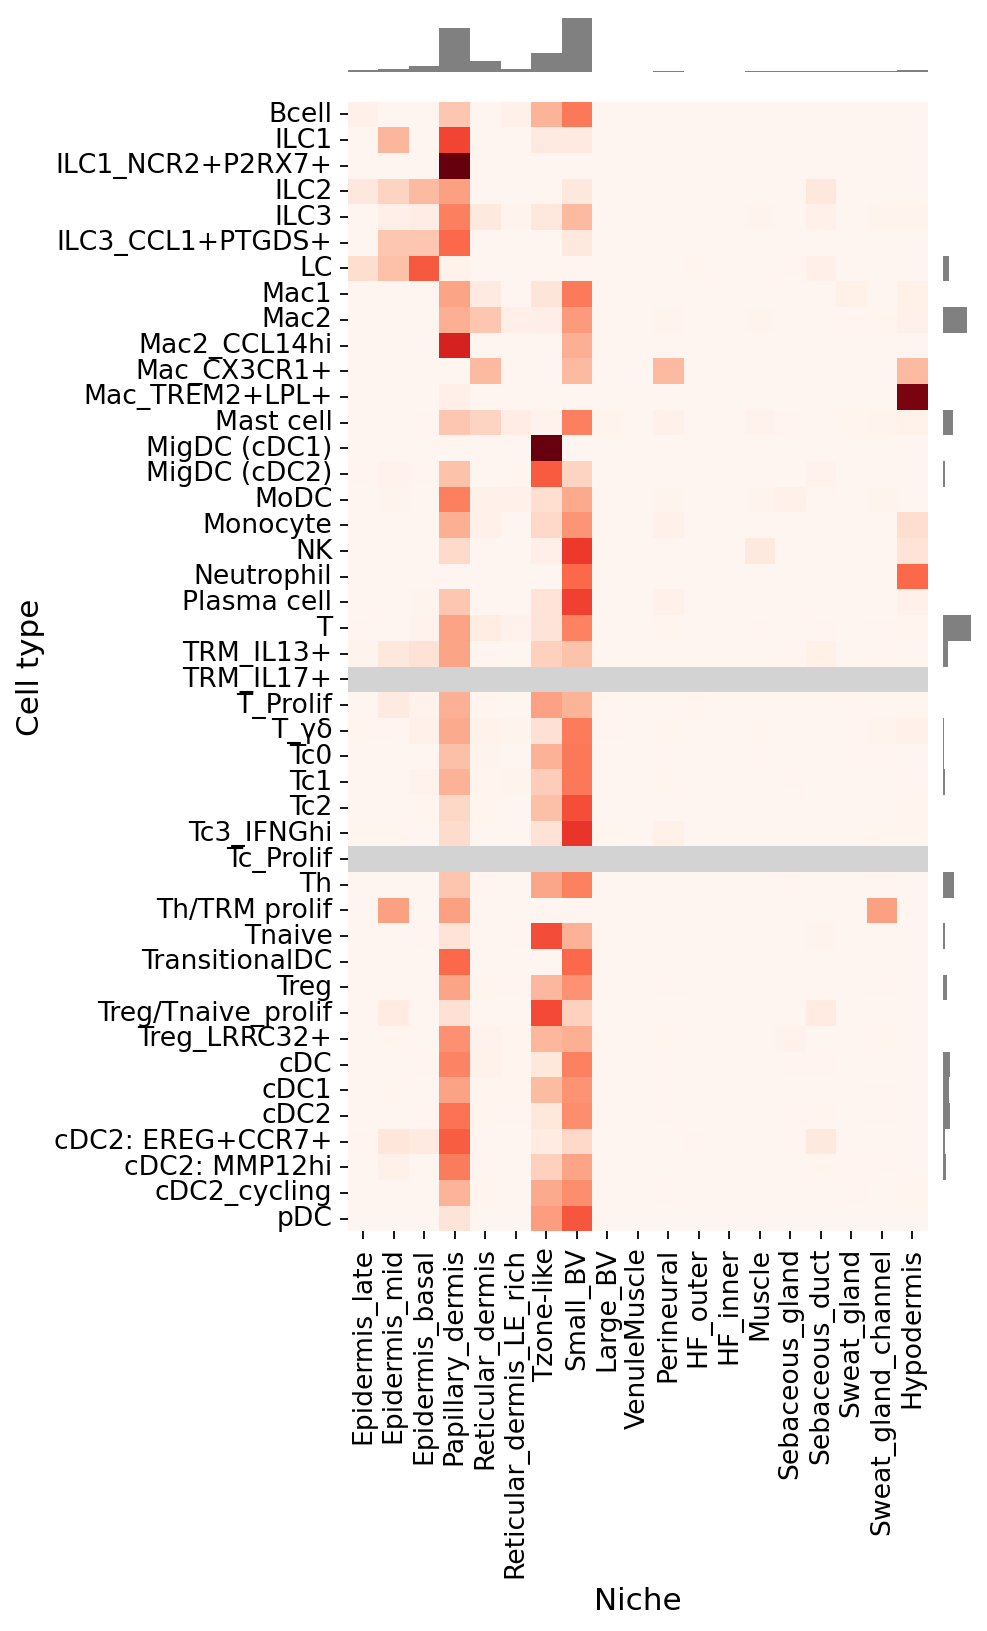

Psoriasis


/tmp/ipykernel_2927642/1697617062.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2927642/1697617062.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


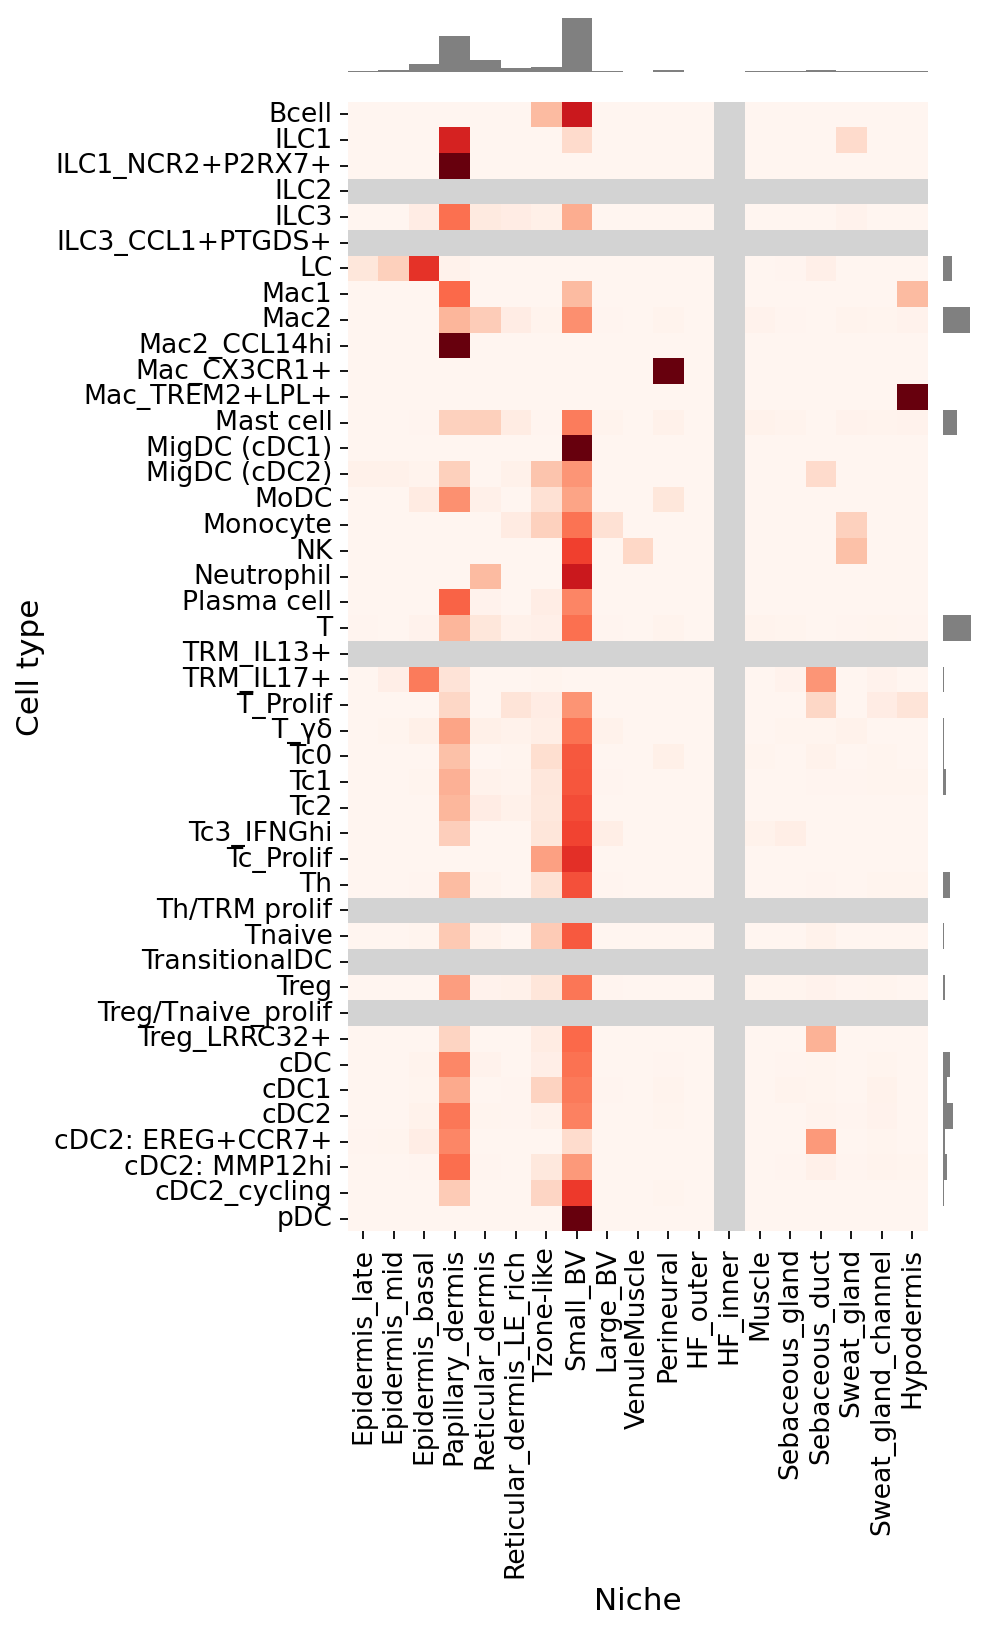

In [14]:
print("Annotations: ", CATEGORY)

all_cell_types = sorted(adata_5k_i.obs[CATEGORY].unique().tolist())


cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for DISEASE in ["AD", "Psoriasis"]:
    print(DISEASE)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == DISEASE]
    
    counts = (
        adata_5k_iii.obs
        .groupby([NICHE, CATEGORY])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index=CATEGORY, columns=NICHE, values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs[NICHE]
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs[CATEGORY]
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(5
                              ,10))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[0.2, 4],  # First value controls top bar height (was 1), make it smaller
        width_ratios=[4, 0.2],   # Second value controls right bar width (was 1), make it smaller
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, #linecolor='white'
    linecolor=None 
        
    )
    ax_heat.set_xlabel('Niche', fontsize=14)
    ax_heat.set_ylabel('Cell type', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)
    ax_heat.set_facecolor('white')  # removes background tint behind NaNs
    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.savefig(f"../2_Fig2/fig2/2c_{DISEASE}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

Annotations:  lvl5_annotation
AD


/tmp/ipykernel_2927642/3073287833.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2927642/3073287833.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


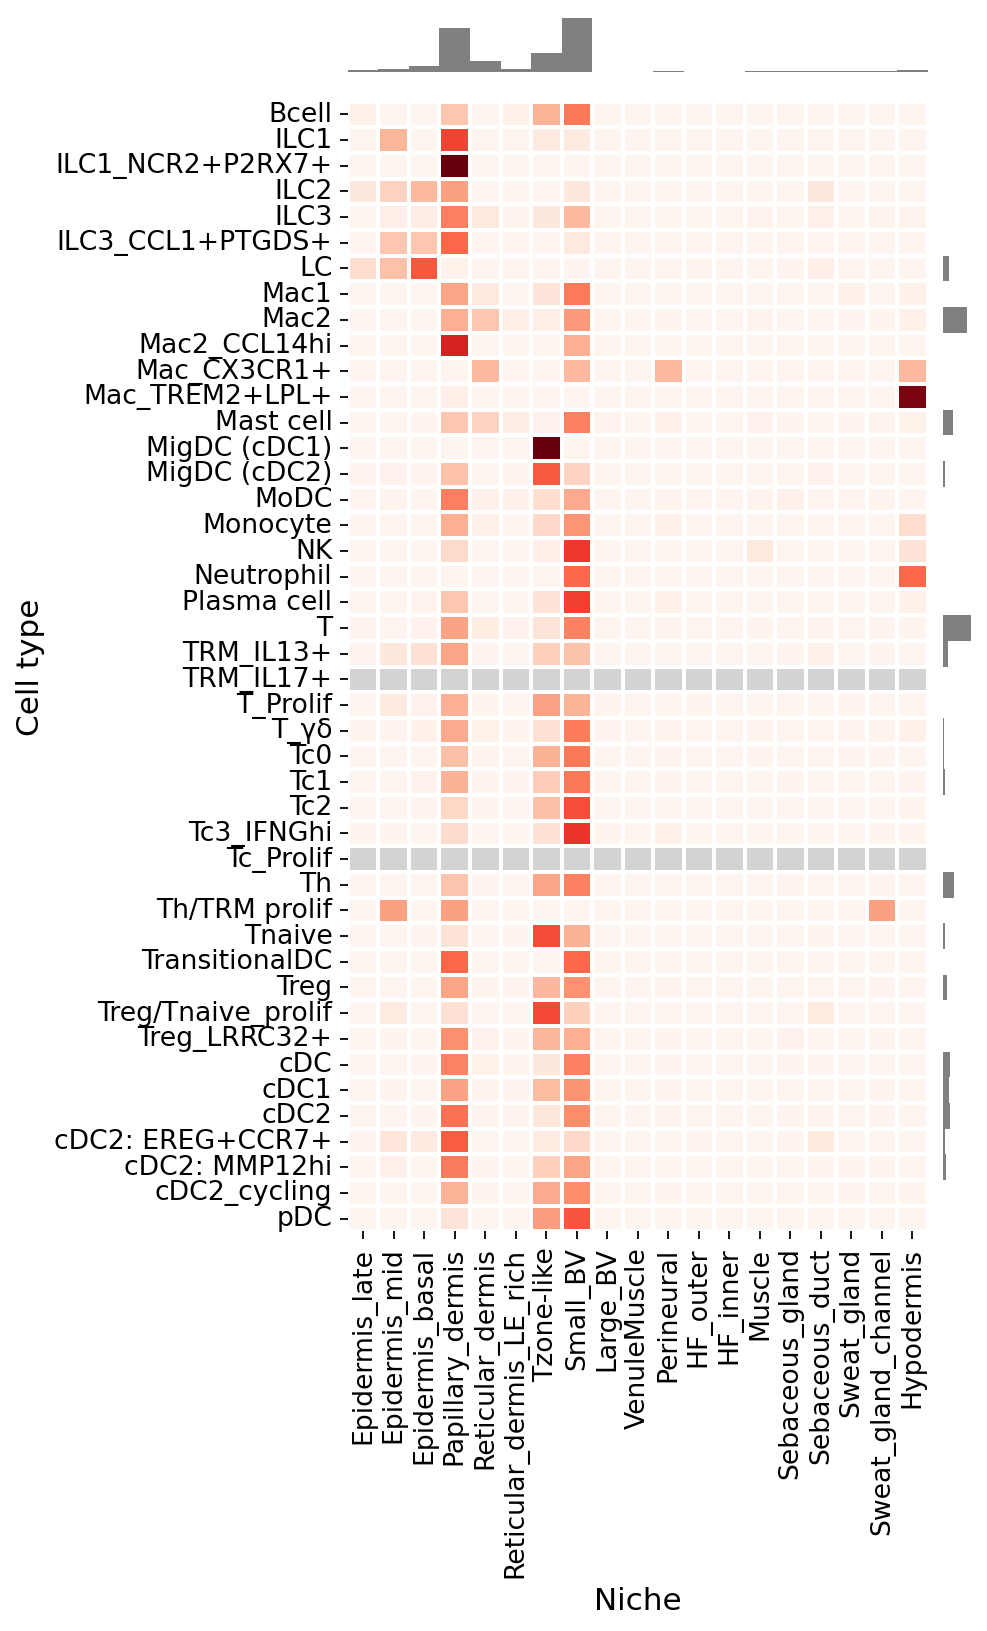

Psoriasis


/tmp/ipykernel_2927642/3073287833.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2927642/3073287833.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


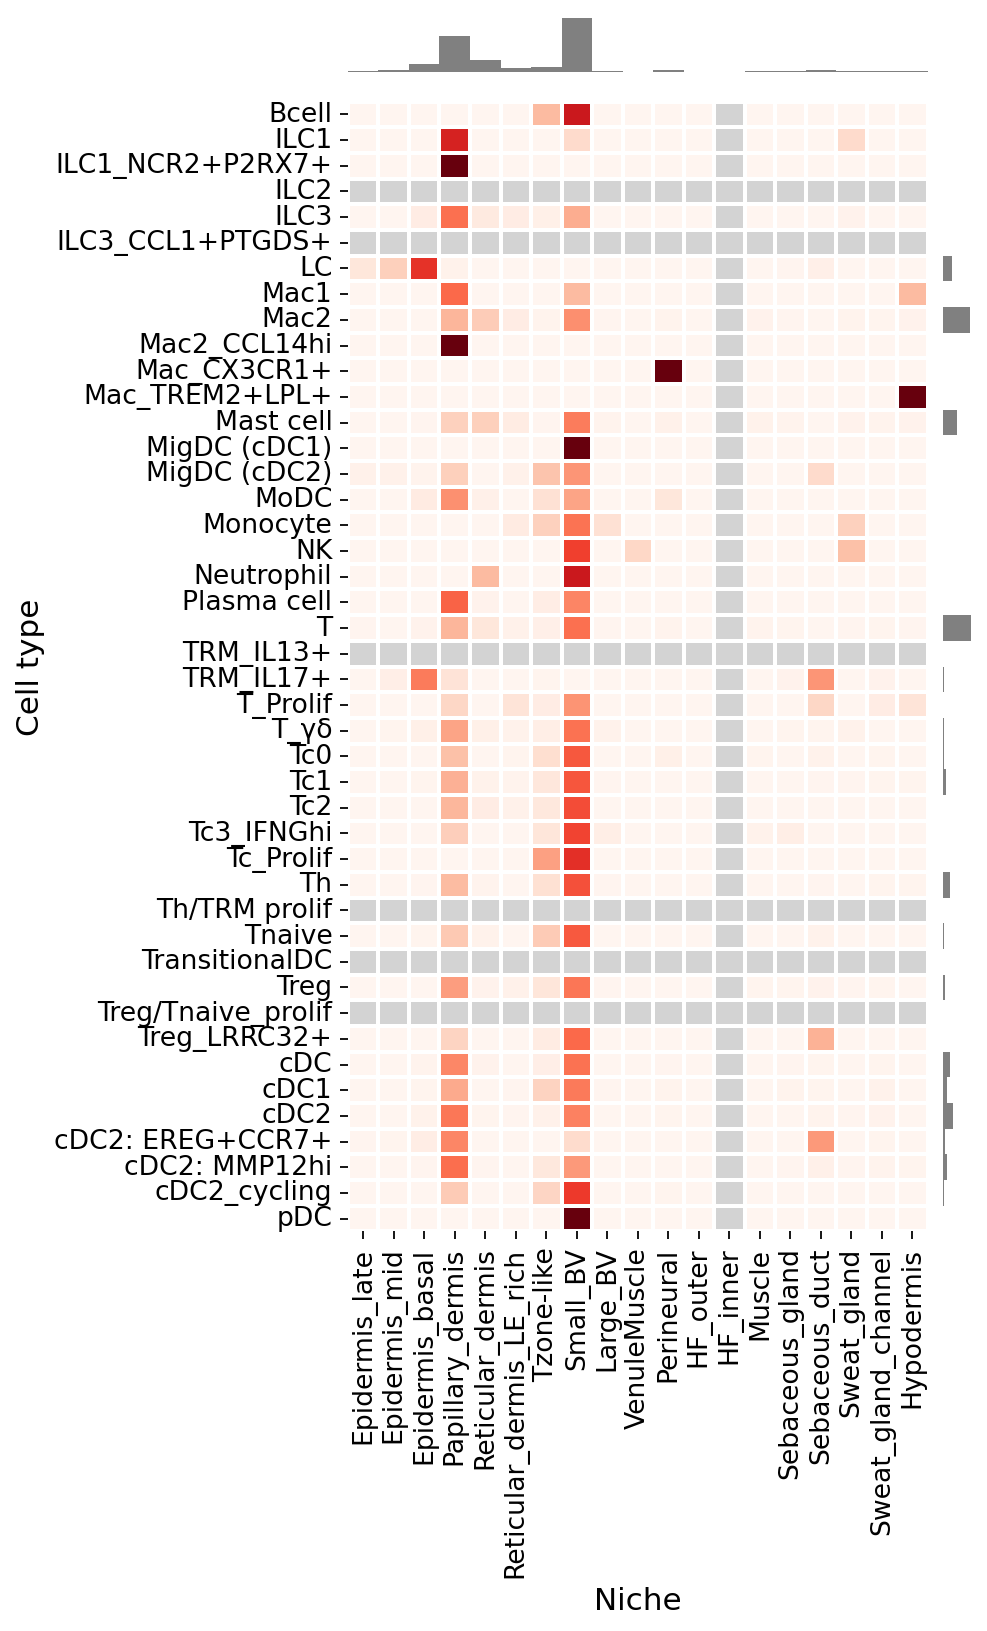

In [15]:
print("Annotations: ", CATEGORY)

all_cell_types = sorted(adata_5k_i.obs[CATEGORY].unique().tolist())


cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for DISEASE in ["AD", "Psoriasis"]:
    print(DISEASE)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == DISEASE]
    
    counts = (
        adata_5k_iii.obs
        .groupby([NICHE, CATEGORY])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index=CATEGORY, columns=NICHE, values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs[NICHE]
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs[CATEGORY]
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(5
                              ,10))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[0.2, 4],  # First value controls top bar height (was 1), make it smaller
        width_ratios=[4, 0.2],   # Second value controls right bar width (was 1), make it smaller
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, 
        linecolor='white'
   # linecolor=None 
        
    )
    ax_heat.set_xlabel('Niche', fontsize=14)
    ax_heat.set_ylabel('Cell type', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)
    ax_heat.set_facecolor('white')  # removes background tint behind NaNs
    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.savefig(f"../2_Fig2/fig2/2c_{DISEASE}_grid.pdf", dpi=300, bbox_inches="tight")
    plt.show()

In [16]:
IMMUNE_CELLS = adata_5k_i.obs["lvl5_annotation"].unique().tolist()
IMMUNE_CELLS

['Th',
 'LC',
 'TRM_IL13+',
 'MigDC (cDC2)',
 'Mac2',
 'T',
 'cDC2: MMP12hi',
 'T_γδ',
 'Treg',
 'cDC2',
 'Mast cell',
 'Tnaive',
 'T_Prolif',
 'cDC',
 'Tc1',
 'cDC2: EREG+CCR7+',
 'cDC1',
 'Tc0',
 'Tc3_IFNGhi',
 'cDC2_cycling',
 'Tc2',
 'Monocyte',
 'Bcell',
 'NK',
 'Treg_LRRC32+',
 'MoDC',
 'pDC',
 'ILC3',
 'Plasma cell',
 'Mac_TREM2+LPL+',
 'Neutrophil',
 'Mac1',
 'Mac_CX3CR1+',
 'ILC3_CCL1+PTGDS+',
 'ILC2',
 'ILC1',
 'Mac2_CCL14hi',
 'Treg/Tnaive_prolif',
 'ILC1_NCR2+P2RX7+',
 'MigDC (cDC1)',
 'Th/TRM prolif',
 'TransitionalDC',
 'TRM_IL17+',
 'Tc_Prolif']

# Non-lesional: Non-immune (eFig 4d)

In [17]:
adata_5k_i = adata_5k[          #(adata_5k.obs["Timepoint"].str.startswith("Past"))|

                  
                                            (adata_5k.obs["Site_status"].str.startswith("Base"))|
                                                      (adata_5k.obs["Site_status"].str.startswith("Never"))|
                           (adata_5k.obs["Site_status"].str.startswith("Non"))|
       (adata_5k.obs["Site_status"]=="Healthy")
                   ]
#adata_5k.obs["Site_status"].value_counts()
adata_5k_i.obs["Site_status"].value_counts()

Site_status
Non-lesional    365833
Healthy          59315
Name: count, dtype: int64

In [18]:
adata_5k_i=adata_5k_i[~adata_5k_i.obs["lvl5_annotation"].isin(IMMUNE_CELLS)]


In [19]:
counts = adata_5k_i.obs['niche19'].value_counts()
keep_niches = counts[counts >= 10].index.tolist()
adata_5k_i = adata_5k_i[adata_5k_i.obs['niche19'].isin(keep_niches)].copy()
adata_5k_i.obs['niche19'] = adata_5k_i.obs['niche19'].cat.remove_unused_categories()
adata_5k_i.obs['niche19'].value_counts()


niche19
Small_BV                    78159
Epidermis_basal             65240
Epidermis_late              38495
Epidermis_mid               30994
Papillary_dermis            28733
Reticular_dermis            23811
EpidermisInflamm_mid        13566
Muscle                      13209
Sweat_gland                 12841
Sweat_gland_channel         11457
Sebaceous_duct              10271
Reticular_dermis_LE_rich     8952
Large_BV                     8629
Perineural                   7375
Sebaceous_gland              6521
HF_outer                     5644
Hypodermis                   4796
Tzone-like                    594
VenuleMuscle                  530
HF_inner                      453
Sebaceous_immune              305
EpidermisInflamm_late         147
Epidermis_basal_cycling       133
Epidermis_APChi                12
Name: count, dtype: int64

In [20]:
adata_5k_i.obs[CATEGORY].value_counts()

lvl5_annotation
beacon_ffpe                       59303
KC3                               46158
KC1                               42083
F2: Universal                     33622
Pericyte1                         25315
VE3_Ven                           21186
F1: Superficial                   18313
KC5                               18226
KC                                12165
Smooth muscle                      7993
Pericyte2_VSMC                     7507
Sweat gland                        7263
nmSchwann                          5958
VE1_Art                            5887
F3: FRC-like                       5627
Sweat gland channel outer          5236
F2/3: Perivascular                 4866
LE                                 4704
VE4_Cap                            4522
Melanocyte                         3818
Sweat gland channel inner          2764
KC1-2_cycling                      2657
KC_Sebocyte_GlandBasal             2636
KC_HF: ORS0                        2326
F5: RAMP1+              

In [21]:
all_cell_types = sorted(adata_5k_i.obs[CATEGORY].unique().tolist())
#all_cell_types

In [22]:
all_cell_types=['Adipocyte',
 'F1: Superficial',
 'F2/3: Perivascular',
 'F2: Universal',
 'F3: FRC-like',
 'F4: DP_HHIP+',
 'F4: DS_DPEP1+',
 'F4: TNN+COCH+',
 'F5: NGFR+',
 'F5: RAMP1+',
 'F6: Inflammatory myofibroblast',
 
 'KC',
 'KC1',
 'KC1-2_cycling',
 'KC2',
 'KC2/3_cycling',
 'KC3',
 'KC4',
 'KC5',
'KCinflamm_basal',
 'KCinflamm_int/late',
 'KC_HF: HFSC',
 'KC_HF: HS',
 'KC_HF: IRS0',
 'KC_HF: IRS1',
 'KC_HF: IRS_Cuticle',
 'KC_HF: Matrix',
 'KC_HF: ORS0',
 'KC_HF: ORS1',
 'KC_HF: ORS2',
 'KC_HF: ORS_cycling',
 'KC_HF: ORS_junction',
 'KC_HF: SPON2+',
 'KC_Sebocyte_DuctInner',
 'KC_Sebocyte_DuctInner_Junction',
 'KC_Sebocyte_DuctOuter',
 'KC_Sebocyte_GlandBasal',
 'KC_Sebocyte_GlandInner',

 'LE',
 'Melanocyte',
 'Merkel cell',
 'Pericyte1',
 'Pericyte2_VSMC',
 'Smooth muscle',
 'Sweat gland',
 'Sweat gland Myoepithelial',
 'Sweat gland channel inner',
 'Sweat gland channel outer',
 'VE1_Art',
 'VE2',
 'VE3_Ven',
 'VE3_Ven_APLN+',
 'VE4_Cap',
 #'beacon_ffpe',
 'mSchwann',
 'nmSchwann']

Annotations:  lvl5_annotation
AD


/tmp/ipykernel_2927642/2969096383.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2927642/2969096383.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


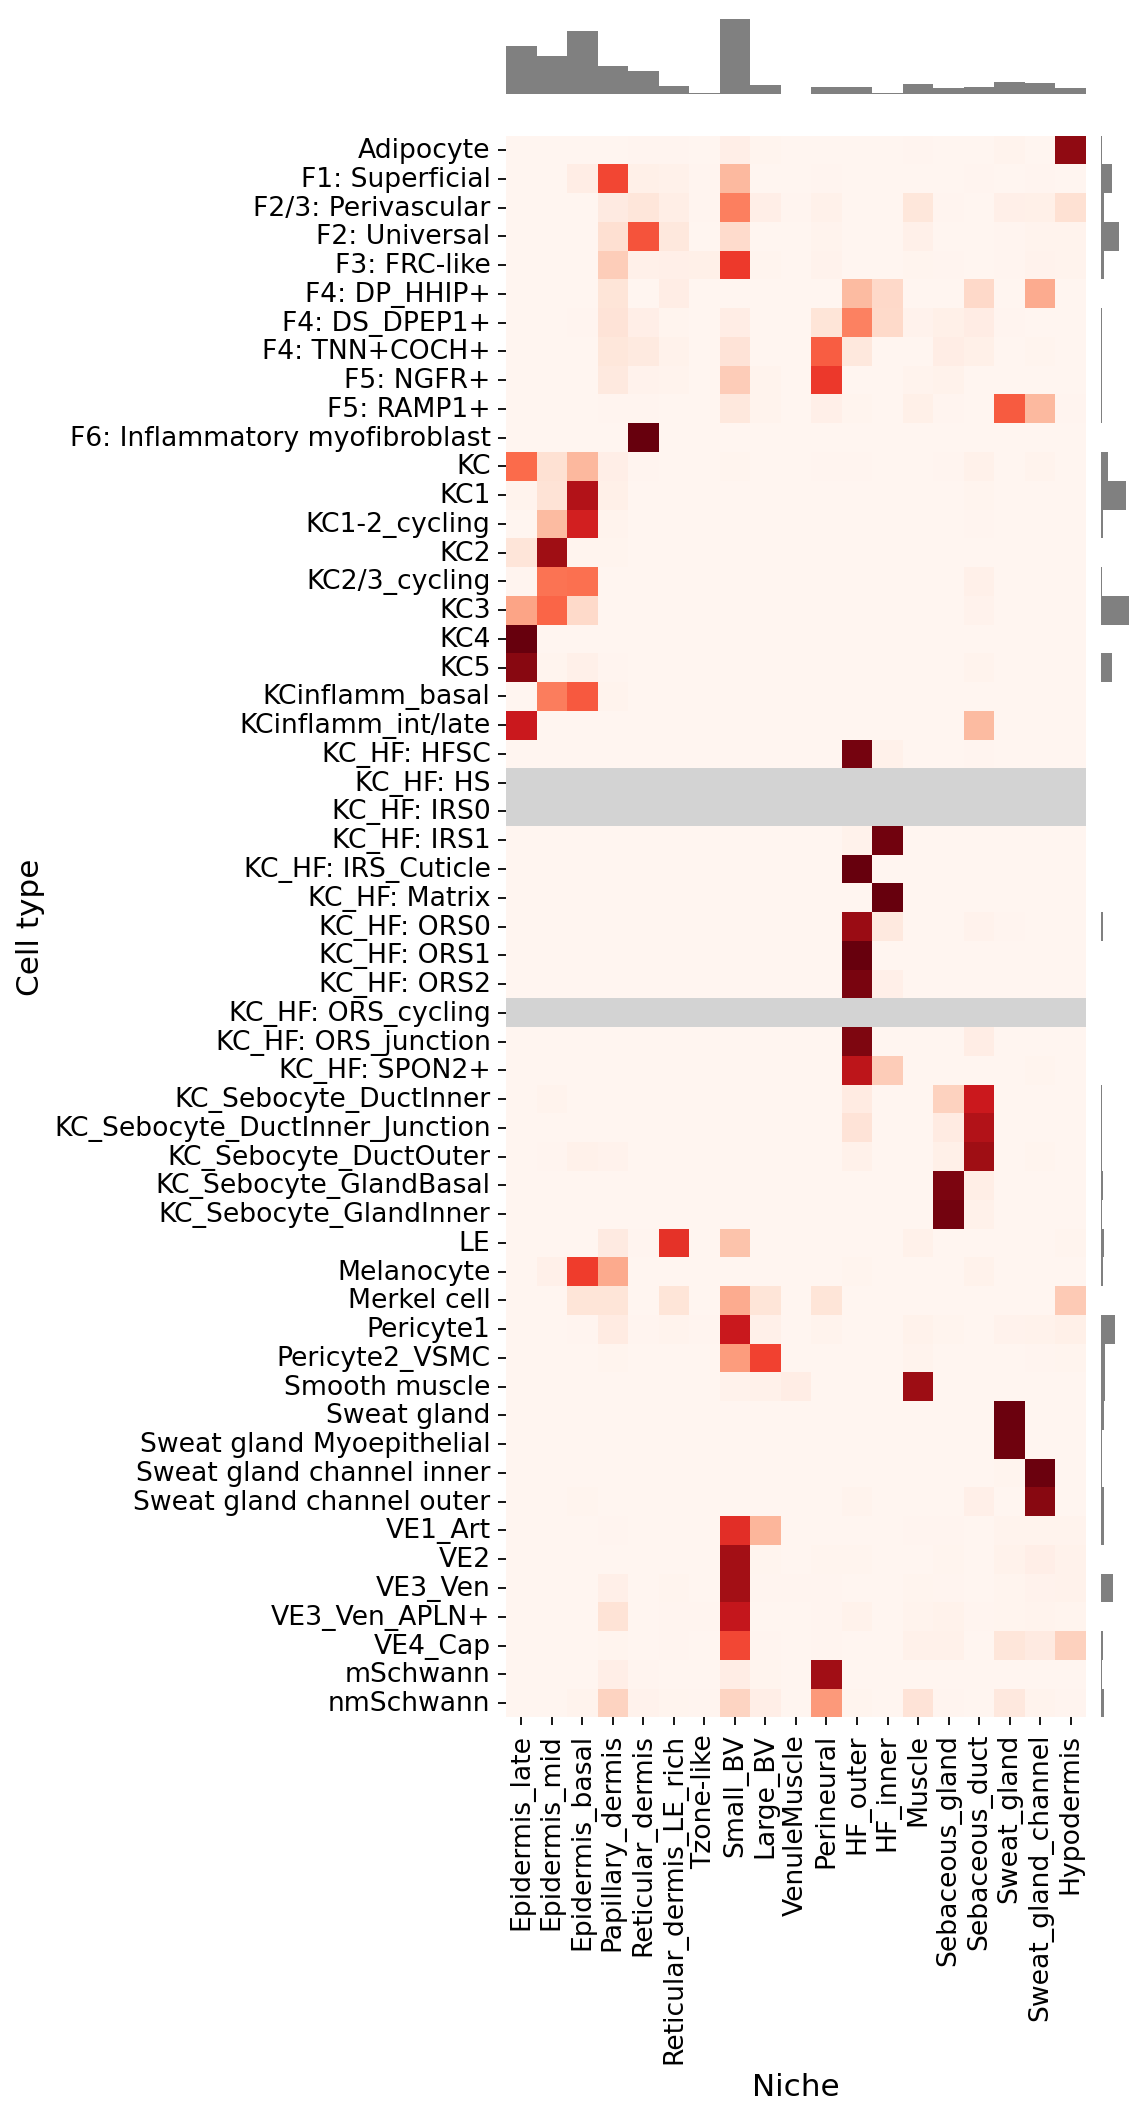

Psoriasis


/tmp/ipykernel_2927642/2969096383.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2927642/2969096383.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


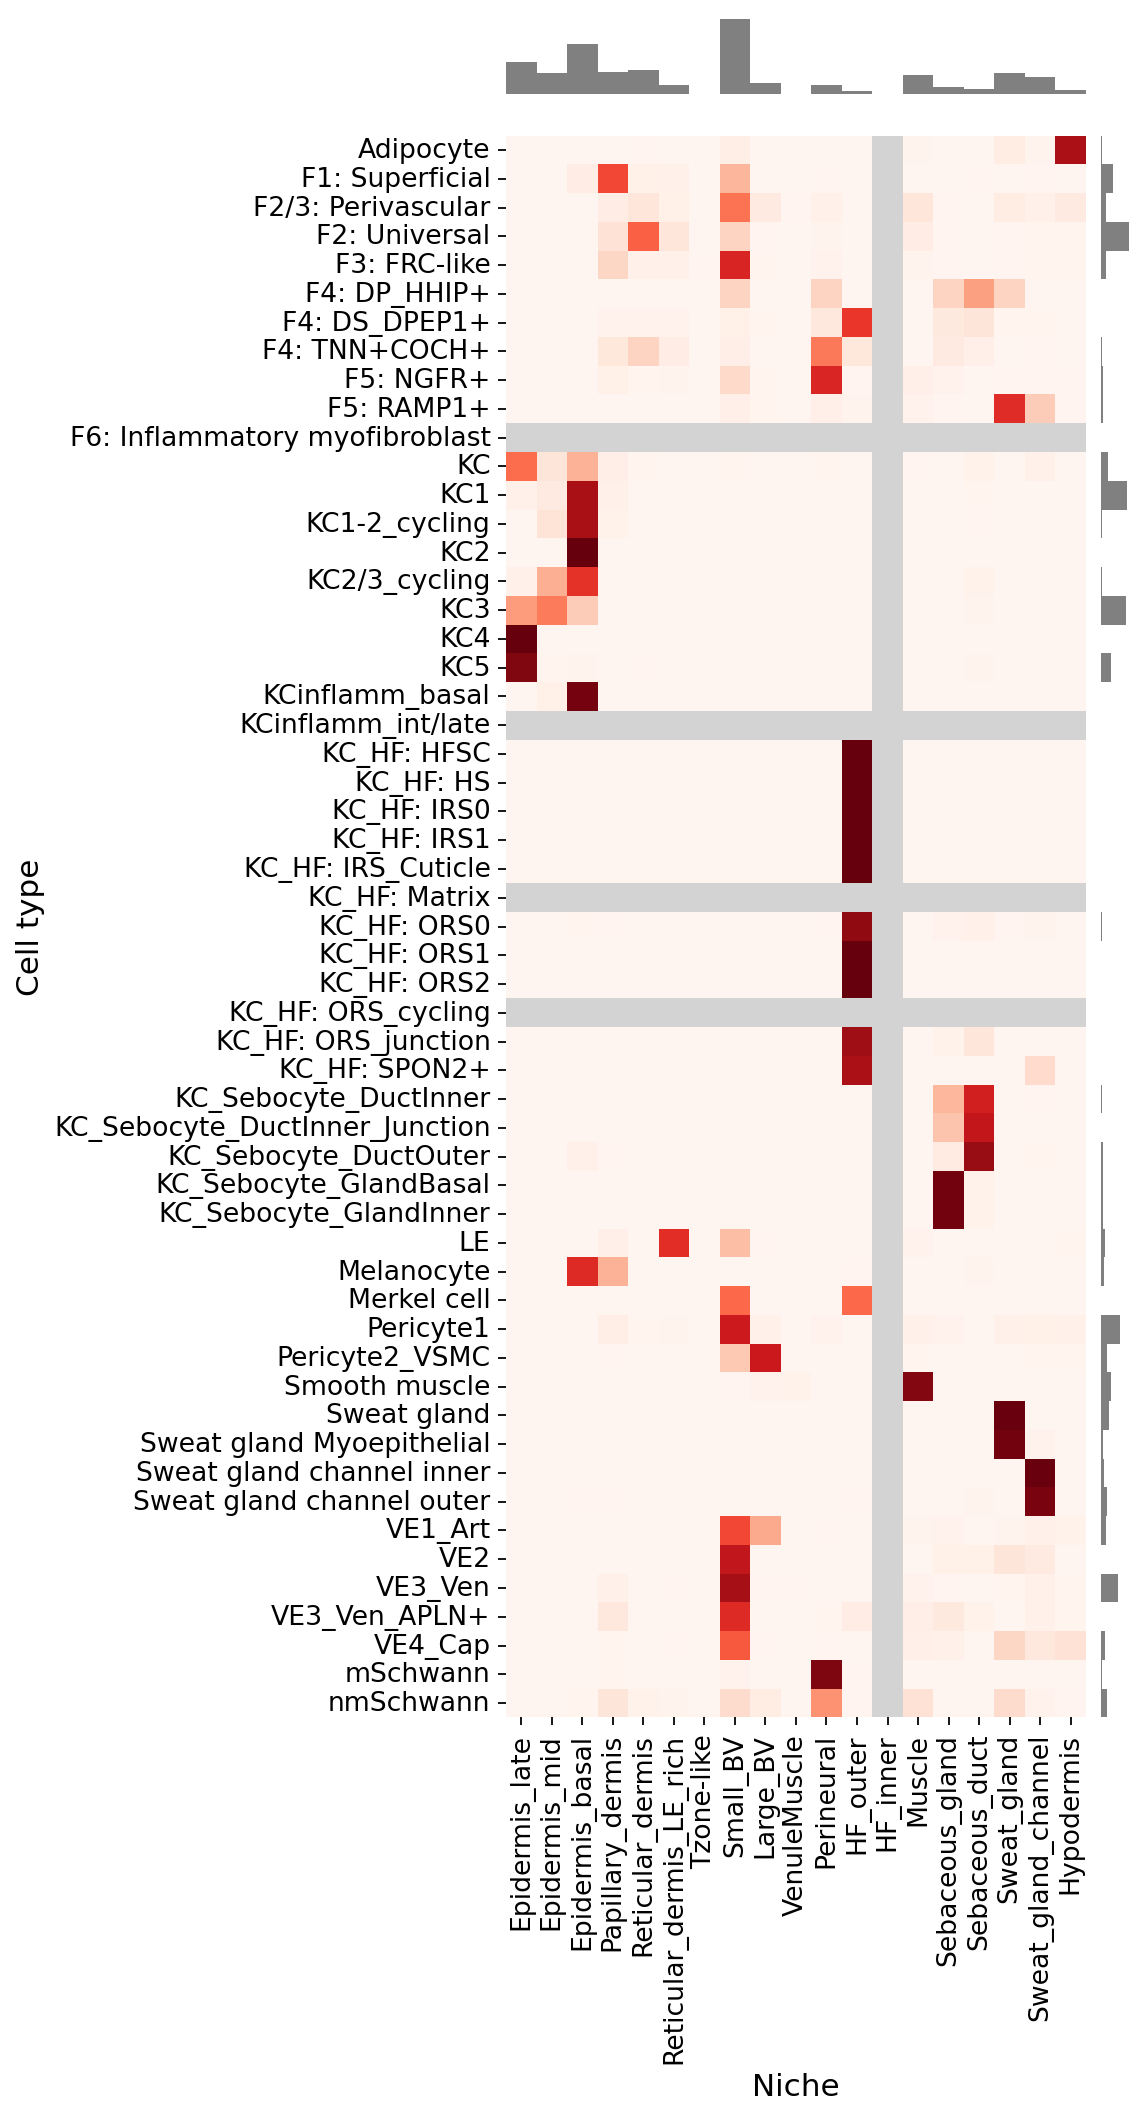

In [23]:
print("Annotations: ", CATEGORY)


cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for DISEASE in ["AD", "Psoriasis"]:
    print(DISEASE)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == DISEASE]
    
    counts = (
        adata_5k_iii.obs
        .groupby([NICHE, CATEGORY])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index=CATEGORY, columns=NICHE, values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs[NICHE]
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs[CATEGORY]
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(5
                              ,14))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[0.2, 4],  # First value controls top bar height (was 1), make it smaller
        width_ratios=[4, 0.2],   # Second value controls right bar width (was 1), make it smaller
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, #linecolor='white'
    linecolor=None 
        
    )
    ax_heat.set_xlabel('Niche', fontsize=14)
    ax_heat.set_ylabel('Cell type', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)
    ax_heat.set_facecolor('white')  # removes background tint behind NaNs
    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.savefig(f"../2_Fig2/fig2/supp_{DISEASE}_nonimmunecells.pdf", dpi=300, bbox_inches="tight")
    plt.show()

In [24]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
adata_5k_i[adata_5k_i.obs["lvl5_annotation"]=="beacon_ffpe"].obs.disease_overall.value_counts()

In [ ]:
print("Annotations: ", CATEGORY)

# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_i.obs[CATEGORY].unique().tolist())

# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for DISEASE in ["AD", "Psoriasis"]:
    print(DISEASE)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == DISEASE]
    
    counts = (
        adata_5k_iii.obs
        .groupby([NICHE, CATEGORY])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index=CATEGORY, columns=NICHE, values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs[NICHE]
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs[CATEGORY]
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(5
                              ,14))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[0.2, 4],  # First value controls top bar height (was 1), make it smaller
        width_ratios=[4, 0.2],   # Second value controls right bar width (was 1), make it smaller
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, 
        linecolor='white'
    #linecolor=None 
        
    )
    ax_heat.set_xlabel('Niche', fontsize=14)
    ax_heat.set_ylabel('Cell type', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)
    ax_heat.set_facecolor('white')  # removes background tint behind NaNs
    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.savefig(f"../2_Fig2/fig2/supp_{DISEASE}_nonimmunecells_grid.pdf", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
# print("Annotations: ", CATEGORY)


# # ---- Desired row and column order ----
# all_cell_types = sorted(adata_5k_i.obs[CATEGORY].unique().tolist())

# # desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# # Set colormap with grey for NaNs
# cmap = mpl.cm.Reds.copy()
# cmap.set_bad(color='lightgrey')

# for x in adata_5k.obs["disease_overall"].unique():
#     print(x)
#     adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
#     counts = (
#         adata_5k_iii.obs
#         .groupby(["niche19", CATEGORY])
#         .size()
#         .reset_index(name="count")
#     )
#     heatmap_data = counts.pivot(index=CATEGORY, columns="niche19", values="count")
#     heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

#     heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

#     plt.figure(figsize=(len(heatmap_data.columns)*0.8, len(heatmap_data)*0.2 + 4))
#     ax = sns.heatmap(
#         heatmap_data,
#         cmap=cmap,
#         annot=False,
#         cbar_kws={"label": "Row Normalized"},
#         vmin=0,
#         vmax=1,
#         linewidths=1,
#         linecolor='white',
#     )
#     plt.title(x, fontsize=18)
#     plt.xlabel("Niche", fontsize=16)
#     plt.ylabel("Cell Type", fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
#     plt.tight_layout()
#     plt.grid(False)
#     plt.show()

In [ ]:
print("Annotations: ", CATEGORY)


# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_i.obs[CATEGORY].unique().tolist())

# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for x in ["AD", "Psoriasis"]:
    print(x)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
    counts = (
        adata_5k_iii.obs
        .groupby(["niche19", CATEGORY])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index=CATEGORY, columns="niche19", values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs['niche12']
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs[CATEGORY]
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[0.2, 4],  # First value controls top bar height (was 1), make it smaller
        width_ratios=[4, 0.2],   # Second value controls right bar width (was 1), make it smaller
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, linecolor='white'
    )
    ax_heat.set_xlabel('Niche', fontsize=14)
    ax_heat.set_ylabel('Cell type', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)

    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.show()

# Lesional

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#%matplotlib inline
sc.settings.figdir = "fig3"
sc.settings.set_figure_params(dpi_save=300, facecolor="white", frameon=False, figsize=(25,25))


In [ ]:
# adata_5k=adata
# adata_5k.obs["Timepoint"].value_counts()


In [ ]:
adata_5k = adata_5k[          #(adata_5k.obs["Timepoint"].str.startswith("Past"))|

                  
                                            (adata_5k.obs["Site_status"].str.startswith("Les"))
#(adata_5k.obs["Timepoint"].str.startswith("Never"))|
                      #     (adata_5k.obs["Timepoint"].str.startswith("Non"))
                   ]
#adata_5k.obs["Site_status"].value_counts()
adata_5k.obs["Site_status"].value_counts()

In [ ]:
adata_5k.obs["Timepoint"].value_counts()

In [ ]:
adata_5k_i = adata_5k[(adata_5k.obs["lvl0"].str.startswith("T"))|
                     (adata_5k.obs[CATEGORY].str.startswith("Plasm"))|
                        (adata_5k.obs[CATEGORY].str.startswith("Bcell"))|
                     (adata_5k.obs["lvl0"]=="Myeloid")|
                         (adata_5k.obs[CATEGORY]=="Mast cell") |
                      (adata_5k.obs[CATEGORY]=="LC_ALOX15hi") 
                      

#                (adata_5k.obs["lvl0"]=="Melanocyte")|
 #               (adata_5k.obs["lvl0"]=="Adipocyte")|
  #             (adata_5k.obs["lvl0"]=="Mast cell")|
   #                (adata_5k.obs["lvl0"]=="Plasma cell/Bcell")
               ]
adata_5k_i.shape



In [ ]:

# desired_order2 = [ 'TRM_IL13+',
#  'TRM_IL17+',
    
#      'Treg',
#  'Treg_LRRC32+',
#                    'Tnaive',
#  'Th',
#  'Th_PPARGhi', 'Tc', 'T_Prolif', 'T', 'T_γδ',
                  
#    'NK',
                  
#  'ILC1',

#  'ILC3',
#  'ILC3_CCL1+PTGDS+',
#  'ILC_prolif',
#      'ILC2',
                  
                  
#                    'Plasma cell',
#       'Bcell',

                  
#  'Monocyte',
#  'Mac',
#  'cDC1',
#                    'MigDC (cDC1)',
#  'cDC2',

#  'cDC2: MMP12hi',
#  'cDC2_cycling', 'MigDC (cDC2)', 'cDC2: EREG+CCR7+',
#                    'LC',



#  'TransitionalDC',


#  'pDC',

#  'Neutrophil',
#      'Mast cell',
    





# ]
# Ensure 'lvl3_annotation' is categorical
if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
    adata_5k_i.obs[CATEGORY] = adata_5k_i.obs[CATEGORY].astype('category')

    
if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
    adata_5k_i.obs[CATEGORY] = adata_5k_i.obs[CATEGORY].astype('category')

missing_data = 0
for x in list(adata_5k_i.obs[CATEGORY].unique()):
    if x not in desired_order2:
        print(x)
        missing_data +=1
if missing_data != 0:
    stop
        
        
# Set the categories in the desired order
adata_5k_i.obs[CATEGORY] = pd.Categorical(
    adata_5k_i.obs[CATEGORY],
    categories=desired_order2,
    ordered=True
)
 
    


adata_5k_i.obs[NICHE].value_counts()

In [ ]:
adata_5k_i.obs[NICHE]=adata_5k_i.obs[NICHE].astype(str)
# 1. Compute counts per niche
counts = adata_5k_i.obs[NICHE].value_counts()

# 2. Keep only niches with ≥10 cells
keep_niches = counts[counts >= 5].index.tolist()

# 3. Subset your AnnData
adata_5k_i = adata_5k_i[adata_5k_i.obs[NICHE].isin(keep_niches)].copy()

# 4. (Optional) If you want nuisance categories removed entirely:
adata_5k_i.obs[NICHE]=adata_5k_i.obs[NICHE].astype('category')
adata_5k_i.obs[NICHE] = adata_5k_i.obs[NICHE].cat.remove_unused_categories()
adata_5k_i.obs[NICHE].value_counts()

In [ ]:
# ANNOTATION = "lvl4_annotation"

In [ ]:
desired_order = [ #'Epidermis_APChi', 
    'Epidermis_late', 
    #'EpidermisInflamm_mid',
    
    'Epidermis_mid', 'Epidermis_basal',
# 'EpidermisInflamm_late', 'EpidermisInflamm_mid', 'Epidermis_basal_cycling',

    
 'Papillary_dermis',
     'Reticular_dermis', #'Reticular_dermis_LErich',
                  'Reticular_dermis_LE_rich',
  
                  'Tzone-like',


#'Plasma_cell_niche',
       'Small_BV',
                  'Large_BV', 'VenuleMuscle',
                  'Perineural',
                #  'HF',
               #  'OuterHF',
    'HF_outer', 'HF_inner', #'HF_innermost',
 'Muscle',
 'Sebaceous_gland', 'Sebaceous_duct', #'Sebaceous_immune', 'Plasma_cell_rich',




                  'Sweat_gland',
 'Sweat_gland_channel',



# 'Sebaceous_immune',
# 'Epidermis_APChi',
                                   'Hypodermis',

 #'Perifollicular_VE',
 #'Epidermis_basal_immune'
                ]


# for x in adata_5k_i.obs[NICHE].unique():
#     if x not in desired_order:
#         print(x)
# desired_order2 = [x for x in desired_order if x in adata_5k_i.obs[NICHE] .unique()]

# Lesional immune - fig 3g

In [ ]:
all_cell_types = sorted(adata_5k_i.obs[ANNOTATION].unique().tolist())

all_cell_types

In [ ]:
ANNOTATION_ORDER = desired_order2
#[ 'TRM_IL13+',
#  'TRM_IL17+',
#      'Treg',
#  'Treg_LRRC32+',
#                      'Th',
#  'Th_PPARGhi', 'Tnaive',
#                      'Tc',

#      'T_γδ',
#                      'T_Prolif',
#                      'T',

                    
#  'NK',

#  'ILC1',
#  'ILC3',
#  'ILC3_CCL1+PTGDS+',
                    
#  'ILC_prolif',
#                      'ILC2',


#                      'Monocyte',
#  'Mac',
#  'LC',
#  'MigDC (cDC2)',
#                      'MigDC (cDC1)',
#  'cDC2: EREG+CCR7+',

#  'cDC2: MMP12hi', 'cDC2_cycling',
#  'cDC2',
#  'cDC1',



#                         'Bcell', 'Plasma cell',
                    





                    
#  'pDC', 
                    
#                      'Neutrophil', 'Mast cell',

                   
#                    ]

In [ ]:
for x in adata_5k.obs[ANNOTATION].unique():
    if x not in ANNOTATION_ORDER:
        print(x)

In [ ]:
0

In [ ]:
for x in adata_5k.obs["disease_overall"].unique():
    print(x)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
    counts = (
        adata_5k_iii.obs
        .groupby([NICHE, ANNOTATION])
        .size()
        .reset_index(name="count")
    )

    heatmap_data = counts.pivot(index=ANNOTATION, columns=NICHE, values="count")
    
    # filter to only cell types in your order
    heatmap_data = heatmap_data[heatmap_data.index.isin(ANNOTATION_ORDER)]
    
    # reindex in desired row order
    heatmap_data = heatmap_data.reindex(index=ANNOTATION_ORDER).fillna(0)

    # also reorder columns if needed
    heatmap_data = heatmap_data.reindex(columns=desired_order).fillna(np.nan)

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

   

    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs[NICHE]
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs[ANNOTATION]
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(12,24))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[0.2, 4],  # First value controls top bar height (was 1), make it smaller
        width_ratios=[4, 0.2],   # Second value controls right bar width (was 1), make it smaller
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    xx = np.arange(len(col_counts))
    ax_colbar.bar(xx, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, linecolor='white'
    )
    ax_heat.set_xlabel('', fontsize=14)
    if x =="AD":
        ax_heat.set_ylabel('Cell type', fontsize=14)
    else:
        ax_heat.set_ylabel(' ', fontsize=1)

    ax_heat.set_xticks(xx+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)

    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.savefig(f"fig3_{x}_proportions.pdf", dpi=300)

    plt.show()

In [ ]:
for disease in adata_5k.obs["disease_overall"].unique():
    print(disease)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == disease]
    
    counts = (
        adata_5k_iii.obs
        .groupby([NICHE, ANNOTATION])
        .size()
        .reset_index(name="count")
    )

    data = counts.pivot(index=ANNOTATION, columns="niche12", values="count")
    data = data[data.index.isin(ANNOTATION_ORDER)]
    data = data.reindex(index=ANNOTATION_ORDER).fillna(0)
    data = data.reindex(columns=desired_order).fillna(0)

    # normalize by row if desired (optional)
    data_prop = data.div(data.sum(axis=1), axis=0)

    # melt into long-form for plotting
    plot_df = data.reset_index().melt(id_vars=ANNOTATION, 
                                      var_name="niche12", 
                                      value_name="count")

    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[0.2, 4], width_ratios=[4, 0.2],
                           hspace=0.05, wspace=0.05)

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_dot    = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # top bar (total per niche)
    col_counts = data.sum(axis=0)
    xx = np.arange(len(col_counts))
    ax_colbar.bar(xx, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # dotplot
    for i, celltype in enumerate(data.index):
        for j, niche in enumerate(data.columns):
            val = data.loc[celltype, niche]
            if val > 0:
                ax_dot.scatter(
                    j+0.5, i+0.5,
                    s=val/np.max(data.values)*500,   # scale dot size
                    c=plt.cm.Blues(val/np.max(data.values)),  # color scale
                    edgecolor="k"
                )

    ax_dot.set_xticks(xx+0.5)
    ax_dot.set_xticklabels(data.columns, rotation=90, fontsize=12)
    ax_dot.set_yticks(np.arange(len(data.index))+0.5)
    ax_dot.set_yticklabels(data.index, fontsize=12)
    ax_dot.invert_yaxis()  # so row order matches heatmap style
    ax_dot.set_xlim(0, len(data.columns))
    ax_dot.set_ylim(0, len(data.index))

    if disease == "AD":
        ax_dot.set_ylabel("Cell type", fontsize=14)
    else:
        ax_dot.set_ylabel(" ", fontsize=1)

    # side bar (total per cell type)
    row_counts = data.sum(axis=1)
    yvals = np.arange(len(row_counts))
    ax_rowbar.barh(yvals, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.savefig(f"fig3_{disease}_dotplot.pdf", dpi=300)
    plt.show()

In [ ]:
"""
One diverging heat-map:

    •  red  → enriched in **Psoriasis**
    •  blue → enriched in **AD** (atopic dermatitis)
    •  grey → fewer than `min_total` cells in both diseases

No side/top bar-plots.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
CATEGORY_CELL  =ANNOTATION
CATEGORY_NICHE = "niche12"
CATEGORY_DIS   = "disease_overall"

min_total = 20           # hide tiles with < min_total total cells

# names must match exactly what is stored in adata.obs["disease_overall"]
DISEASE_PSOR = "Psoriasis"
DISEASE_AD   = "AD"            # atopic dermatitis

# ----------------------------------------------------------------
# 0   safety check
# ----------------------------------------------------------------
present = set(adata_5k_i.obs[CATEGORY_DIS].unique())
if {DISEASE_PSOR, DISEASE_AD} - present:
    raise ValueError(
        f"Diseases not found in '{CATEGORY_DIS}': "
        f"{ {DISEASE_PSOR, DISEASE_AD} - present }"
    )

# diverging cmap (blue-white-red) with grey for NaNs
cmap = mpl.cm.get_cmap("bwr").copy()
cmap.set_bad("lightgrey")

cell_types = sorted(adata_5k_i.obs[CATEGORY_CELL ].unique())
niches     = sorted(adata_5k_i.obs[CATEGORY_NICHE].unique())

# ---------------------------------------------------------------
# 1   helper → row-wise percentages for a single disease
# ---------------------------------------------------------------
def row_percent(adata, disease):
    tbl = (
        adata.obs.loc[adata.obs[CATEGORY_DIS] == disease]
        .groupby([CATEGORY_CELL, CATEGORY_NICHE]).size()
        .unstack(fill_value=0)
        .reindex(index=cell_types, columns=niches, fill_value=0)
    )
    return tbl.div(tbl.sum(axis=1), axis=0)      # row-normalise

prop_psor = row_percent(adata_5k_i, DISEASE_PSOR)
prop_ad   = row_percent(adata_5k_i, DISEASE_AD)

# ---------------------------------------------------------------
# 2   difference matrix  (positive = Psoriasis)
# ---------------------------------------------------------------
diff      = prop_psor - prop_ad
max_abs   = np.abs(diff.values).max() or 1

# ---------------------------------------------------------------
# 3   mask low-count tiles
# ---------------------------------------------------------------
totals = (
    adata_5k_i.obs
    .groupby([CATEGORY_CELL, CATEGORY_NICHE]).size()
    .unstack(fill_value=0)
    .reindex(index=cell_types, columns=niches, fill_value=0)
)

diff_masked = diff.mask(totals < min_total)

# ---------------------------------------------------------------
# 4   plot
# ---------------------------------------------------------------
plt.figure(figsize=(12, 9))
sns.heatmap(
    diff_masked,
    cmap=cmap,
    vmin=-max_abs,
    vmax= max_abs,
    linewidths=.5,
    linecolor="white",
    cbar_kws=dict(label=f"%({DISEASE_PSOR}) − %({DISEASE_AD})"),
)
plt.xlabel("Niche", fontsize=12)
plt.ylabel("Cell type", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0, fontsize=8)
plt.title(
    f"Relative enrichment (row-normalised)\n"
    f"red → {DISEASE_PSOR}  |  blue → {DISEASE_AD}  "
    f"(tiles with <{min_total} total cells greyed)",
    fontsize=14,
)
plt.tight_layout()
plt.show()

In [ ]:
"""
Heat-map only – no side/top bar-plots – and we suppress cells where the
total number of observations (across both diseases) is below a chosen
threshold so that tiny, noisy categories don’t shout in bright red/blue.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
CATEGORY_CELL  = "lvl5_annotation"
CATEGORY_NICHE = "niche12"
CATEGORY_DIS   = "disease_overall"

disease_A, disease_B = sorted(adata_5k_i.obs[CATEGORY_DIS].unique())

min_total = 20           # << hide tiles with < min_total cells
cmap      = mpl.cm.get_cmap("bwr").copy()
cmap.set_bad("lightgrey")

cell_types = sorted(adata_5k_i.obs[CATEGORY_CELL ].unique())
niches     = sorted(adata_5k_i.obs[CATEGORY_NICHE].unique())

# ---------------------------------------------------------------
# 1.  per-disease row-wise % tables
# ---------------------------------------------------------------
def row_percent(adata, disease):
    tbl = (
        adata.obs.loc[adata.obs[CATEGORY_DIS] == disease]
        .groupby([CATEGORY_CELL, CATEGORY_NICHE]).size()
        .unstack(fill_value=0)
        .reindex(index=cell_types, columns=niches, fill_value=0)
    )
    return tbl.div(tbl.sum(axis=1), axis=0)

prop_A = row_percent(adata_5k_i, disease_A)
prop_B = row_percent(adata_5k_i, disease_B)

# difference matrix
diff = prop_A - prop_B
max_abs = np.abs(diff.values).max() or 1

# ---------------------------------------------------------------
# 2.  mask low-count tiles to avoid “rare-cell-type noise”
# ---------------------------------------------------------------
total_counts = (
    adata_5k_i.obs
    .groupby([CATEGORY_CELL, CATEGORY_NICHE]).size()
    .unstack(fill_value=0)
    .reindex(index=cell_types, columns=niches, fill_value=0)
)

diff_masked = diff.mask(total_counts < min_total)

# ---------------------------------------------------------------
# 3.  plot
# ---------------------------------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(
    diff_masked,
    cmap=cmap,
    vmin=-1,
    vmax= 1,
    linewidths=.5,
    linecolor="white",
    cbar_kws=dict(label=f"%({disease_A}) − %({disease_B})"),
)
plt.xlabel("Niche", fontsize=12)
plt.ylabel("Cell type", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0, fontsize=8)
plt.title(f"Enrichment: {disease_A} (red) vs {disease_B} (blue)\n"
          f"tiles with <{min_total} cells hidden", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:

adata_5k_i = adata_5k[#(adata_5k.obs["lvl0"].str.startswith("KC"))|
                     #(adata_5k.obs[CATEGORY].str.startswith("Plasm"))|
                        (adata_5k.obs["lvl0"].str.startswith("VE"))|
                     (adata_5k.obs["lvl0"].str.startswith("Fibr"))|
                     #    (adata_5k.obs["lvl0"]=="KC_Ap") |
                      (adata_5k.obs["lvl0"]=="Other") 
                      

#                (adata_5k.obs["lvl0"]=="Melanocyte")|
 #               (adata_5k.obs["lvl0"]=="Adipocyte")|
  #             (adata_5k.obs["lvl0"]=="Mast cell")|
   #                (adata_5k.obs["lvl0"]=="Plasma cell/Bcell")
               ]
adata_5k_i=adata_5k_i[adata_5k_i.obs[CATEGORY]!="Plasma cell"]
adata_5k_i=adata_5k_i[adata_5k_i.obs[CATEGORY]!="Bcell"]
#adata_5k_i.obs
counts = adata_5k_i.obs['niche12'].value_counts()
keep_niches = counts[counts >= 10].index.tolist()

# 3. Subset your AnnData
adata_5k_i = adata_5k_i[adata_5k_i.obs['niche12'].isin(keep_niches)].copy()

# 4. (Optional) If you want nuisance categories removed entirely:
adata_5k_i.obs['niche12'] = adata_5k_i.obs['niche12'].cat.remove_unused_categories()
adata_5k_i.obs['niche12'].value_counts()


In [ ]:


# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_i.obs["lvl5_annotation"].unique().tolist())

# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for x in adata_5k.obs["disease_overall"].unique():
    print(x)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs['niche12']
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs['lvl5_annotation']
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[1,4],
        width_ratios=[4,1],
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, linecolor='white'
    )
    ax_heat.set_xlabel('Niche', fontsize=14)
    ax_heat.set_ylabel('Cell type', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)

    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:


# # ---- Desired row and column order ----
# all_cell_types = sorted(adata_5k_i.obs["lvl5_annotation"].unique().tolist())

# # desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# # Set colormap with grey for NaNs
# cmap = mpl.cm.Reds.copy()
# cmap.set_bad(color='lightgrey')

# for x in adata_5k.obs["disease_overall"].unique():
#     print(x)
#     adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
#     counts = (
#         adata_5k_iii.obs
#         .groupby(["niche12", "lvl5_annotation"])
#         .size()
#         .reset_index(name="count")
#     )
#     heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
#     heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    
#     # ---- Min-max normalization per row ----
#     heatmap_data = (heatmap_data - heatmap_data.min(axis=1).values[:, None]) / (
#         heatmap_data.max(axis=1).values[:, None] - heatmap_data.min(axis=1).values[:, None]
#     )
    
#     plt.figure(figsize=(len(heatmap_data.columns)*0.4, len(heatmap_data)*0.2 + 4))
#     ax = sns.heatmap(
#         heatmap_data,
#         cmap=cmap,
#         annot=False,
#         cbar_kws={"label": "Row Min-Max Normalized"},
#         vmin=0,
#         vmax=1,
#         linewidths=1,
#         linecolor='white',
#     )
#     plt.title(x, fontsize=18)
#     plt.xlabel("Niche", fontsize=16)
#     plt.ylabel("Cell Type", fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
#     plt.tight_layout()
#     plt.grid(False)
#     plt.show()

# Lesional only

In [ ]:
# adata_5k_i = adata_5k[(adata_5k.obs["lvl0"].str.startswith("T"))|
#                      (adata_5k.obs[CATEGORY].str.startswith("Plasm"))|
#                         (adata_5k.obs[CATEGORY].str.startswith("Bcell"))|
#                      (adata_5k.obs["lvl0"]=="Myeloid")|
#                          (adata_5k.obs[CATEGORY]=="Mast cell") |
#                       (adata_5k.obs[CATEGORY]=="LC_ALOX15hi") 
                      

# #                (adata_5k.obs["lvl0"]=="Melanocyte")|
#  #               (adata_5k.obs["lvl0"]=="Adipocyte")|
#   #             (adata_5k.obs["lvl0"]=="Mast cell")|
#    #                (adata_5k.obs["lvl0"]=="Plasma cell/Bcell")
#                ]
# adata_5k_i.shape

# desired_order2 =  ['Treg','Treg_LRRC32','Treg_LRRC32+', 'TR1', 'Tnaive','Tnaive/T_cm', 'Tnaive/Tcm', 'T_polarized_CCR6+','Th', 'Tc',
#                  'Tc_IFNGhi',"Tc_ZNF683+",
#             'Tc_IL13','TRM_IL13',"TRM_IL13+",
# 'TRM_IL17', "TRM_IL17+", 'T','T_polarized',
                
                 







                
#                  'T_Prolif','T_prolif',
#                   "NK", "ILC1/NK","ILC_prolif","ILC2/3",
              
#                   "Monocyte",
#                   'Monocyte?', 'Mac','Macint','Mac_TREM2+LPL+',
#  'Mac2_CCL14hi','Mac_CCL14hi','MacCCL14_hi','Mac_LPLhi', 'Mac LPLhi (P2RY12-)',
#                   'Mac LPLhi','Mac_TREM+','Mac_Perineural?',"Mac_CX3CR1+",
#                   'Mac_prolif/PreDC', 'TransitionalDC',
#                    "Mac_prolif/preDC",
# 'Mac_prolif',

















#  'cDC1',
#  'cDC2', 'cDC2_MMP12',   'cDC2: MMP12+', 'cDC2: MMP12hi', "cDC2: MMP12+IL1B+",'cDC2: THBS1+',
#                   'MoDC/cDC2','MoDC','cDC2_MoDC(C1QTNF1+KDR+)','cDC2_MoDC (THBS1+)', 'cDC2_THBS1+','LC/MoDC_MMP12+/CXCL9+',
#                   'cMoDC/cDC (C1QTNF1+KDR+)','MoDC?','MoDC_lowqithink?',

#                    'LC_CCR7+','LC_SLC18A2+',
#  'LC','LC_ALOX15hi',
# 'cDC2_MMP12hi (Mig)','cDC: MMP12+/CXCL9+',
#  'MigDC','MigDC_T_doublet',
#  'pDC',"Mast cell", "Neutrophil",
                 
#                   'DC2/Mac',
#                   "Bcell",  'Plasma cell',



 

# ]


# # Ensure 'lvl3_annotation' is categorical
# if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
#     adata_5k_i.obs[CATEGORY] = adata_5k_i.obs[CATEGORY].astype('category')

    
# if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
#     adata_5k_i.obs[CATEGORY] = adata_5k_i.obs[CATEGORY].astype('category')

# missing_data = 0
# for x in list(adata_5k_i.obs[CATEGORY].unique()):
#     if x not in desired_order2:
#         print(x)
#         missing_data +=1
# if missing_data != 0:
#     stop
        
        
# # Set the categories in the desired order
# adata_5k_i.obs[CATEGORY] = pd.Categorical(
#     adata_5k_i.obs[CATEGORY],
#     categories=desired_order2,
#     ordered=True
# )
 
    




In [ ]:
adata_5k_ii=adata_5k_i[adata_5k_i.obs["Site_status"]=="Lesional"]

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib as mpl

# # Define column (niche) order manually if you want consistent x-axis
# #desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # Replace with your actual column order

# # Get all unique cell types once, before the loop
# all_cell_types = adata_5k_i.obs["final_annotation_lvl4"].unique().tolist()

# # Use a custom Reds colormap with grey for missing data
# cmap = mpl.cm.Reds.copy()
# cmap.set_bad(color='lightgrey')

# for x in adata_5k_i.obs["disease_overall"].unique():
#     print(x)
    
#     # Subset for this disease
#     adata_5k_ii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
#     # Step 1: Count of each cell type per niche
#     counts = (
#         adata_5k_ii.obs
#         .groupby(["niche11", "final_annotation_lvl4"])
#         .size()
#         .reset_index(name="count")
#     )
    
#     # Step 2: Pivot to wide format
#     heatmap_data = counts.pivot(index="final_annotation_lvl4", columns="niche11", values="count")
    
#     # Step 3: Reindex to include all cell types (missing ones become NaN)
#     all_cell_types = sorted(adata_5k_i.obs["final_annotation_lvl4"].unique().tolist())

#     # Then in the loop:
#     heatmap_data = heatmap_data.reindex(all_cell_types).fillna(np.nan)    
#     # Step 4: Normalize by column (niche-wise)
#     heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)
    
#     # Step 5: Reorder columns, filter for niches present in this disease
#     desired_order2 = [n for n in desired_order if n in heatmap_data.columns]
#     heatmap_data = heatmap_data[desired_order2]
    
#     # Step 6: Plot
#     plt.figure(figsize=(len(heatmap_data.columns)*0.7, len(heatmap_data)*0.4 + 4))
#     sns.heatmap(
#         heatmap_data,
#         cmap=cmap,
#         annot=False,
#         cbar_kws={"label": "Column-normalized Proportion"},
#         vmin=0,
#         vmax=1,
#         linewidths=1,
#         linecolor='white',
#     )
    
#     plt.title(x)
#     plt.xlabel("Niche")
#     plt.ylabel("Cell Type")
#     plt.xticks(rotation=90)
#     plt.tight_layout()
#     plt.grid(False)
#     plt.show()


In [ ]:
adata_5k_ii

In [ ]:
adata_5k_ii.obs["disease_overall"].unique()

In [ ]:
adata_5k_i.obs["niche12"].value_counts()

In [ ]:
# 1. Compute counts per niche
counts = adata_5k_i.obs['niche12'].value_counts()

# 2. Keep only niches with ≥10 cells
keep_niches = counts[counts >= 10].index.tolist()

# 3. Subset your AnnData
adata_5k_i = adata_5k_i[adata_5k_i.obs['niche12'].isin(keep_niches)].copy()

# 4. (Optional) If you want nuisance categories removed entirely:
adata_5k_i.obs['niche12'] = adata_5k_i.obs['niche12'].cat.remove_unused_categories()
adata_5k_i.obs['niche12'].value_counts()

In [ ]:

desired_order2 =  ['Treg','Treg_LRRC32','Treg_LRRC32+', 'TR1', 'Tnaive','Tnaive/T_cm', 'Tnaive/Tcm', 'T_polarized_CCR6+','Th', 'Tc',
                 'Tc_IFNGhi',"Tc_ZNF683+",
            'Tc_IL13','TRM_IL13',"TRM_IL13+",
'TRM_IL17', "TRM_IL17+", 'T','T_polarized',
                
                 







                
                 'T_Prolif','T_prolif',
                  "NK", "ILC1/NK","ILC_prolif","ILC2/3",
              
                  "Monocyte",
                  'Monocyte?', 'Mac','Macint','Mac_TREM2+LPL+',
 'Mac2_CCL14hi','Mac_CCL14hi','MacCCL14_hi','Mac_LPLhi', 'Mac LPLhi (P2RY12-)',
                  'Mac LPLhi','Mac_TREM+','Mac_Perineural?',"Mac_CX3CR1+",
                  'Mac_prolif/PreDC', 'TransitionalDC',
                   "Mac_prolif/preDC",
'Mac_prolif',

















 'cDC1',
 'cDC2', 'cDC2_MMP12',   'cDC2: MMP12+', 'cDC2: MMP12hi', "cDC2: MMP12+IL1B+",'cDC2: THBS1+',
                  'MoDC/cDC2','MoDC','cDC2_MoDC(C1QTNF1+KDR+)','cDC2_MoDC (THBS1+)', 'cDC2_THBS1+','LC/MoDC_MMP12+/CXCL9+',
                  'cMoDC/cDC (C1QTNF1+KDR+)','MoDC?','MoDC_lowqithink?',

                   'LC_CCR7+','LC_SLC18A2+',
 'LC','LC_ALOX15hi',
'cDC2_MMP12hi (Mig)','cDC: MMP12+/CXCL9+',
 'MigDC','MigDC_T_doublet',
 'pDC',"Mast cell", "Neutrophil",
                 
                  'DC2/Mac',
                  "Bcell",  'Plasma cell',



 

]
 
desired_order2=[x for x in adata_5k_ii.obs[CATEGORY].unique()]
    
if not pd.api.types.is_categorical_dtype(adata_5k_ii.obs[CATEGORY]):
    adata_5k_ii.obs[CATEGORY] = adata_5k_ii.obs[CATEGORY].astype('category')

missing_data = 0
for x in list(adata_5k_ii.obs[CATEGORY].unique()):
    if x not in desired_order2:
        print(x)
        missing_data +=1
if missing_data != 0:
    stop
        
        
# Set the categories in the desired order
adata_5k_ii.obs[CATEGORY] = pd.Categorical(
    adata_5k_ii.obs[CATEGORY],
    categories=desired_order2,
    ordered=True
)
 
    




In [ ]:

# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_ii.obs["lvl5_annotation"].unique().tolist())
# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for x in adata_5k_i.obs["disease_overall"].unique():
    print(x)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
    #heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    # after pivot…
    heatmap_data = counts.pivot(
    index="lvl5_annotation",
    columns="niche12",
    values="count"
).reindex(
    index=desired_order2,   # ← use your custom order here
    columns=desired_order   # (assuming you’ve already defined desired_order)
).fillna(0)

# then normalize, plot, etc.
    # ---- Min-max normalization per row ----
    heatmap_data = (heatmap_data - heatmap_data.min(axis=1).values[:, None]) / (
        heatmap_data.max(axis=1).values[:, None] - heatmap_data.min(axis=1).values[:, None]
    )
    
    plt.figure(figsize=(len(heatmap_data.columns)*0.4, len(heatmap_data)*0.2 + 4))
    ax = sns.heatmap(
        heatmap_data,
        cmap=cmap,
        annot=False,
        cbar_kws={"label": "Row Min-Max Normalized"},
        vmin=0,
        vmax=1,
        linewidths=1,
        linecolor='white',
    )
    plt.title(x, fontsize=18)
    plt.xlabel("Niche", fontsize=16)
    plt.ylabel("Cell Type", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [ ]:
for x in all_cell_types:
    if x not in desired_order2:
        print(x)

In [ ]:
for x in desired_order2 :
    if x not in all_cell_types:
        print(x)

In [ ]:


# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_i.obs["lvl5_annotation"].unique().tolist())

# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for x in adata_5k.obs["disease_overall"].unique():
    print(x)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs['niche12']
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs['lvl5_annotation']
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[1,4],
        width_ratios=[4,1],
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, linecolor='white'
    )
    ax_heat.set_xlabel('Niche', fontsize=14)
    ax_heat.set_ylabel('Cell type', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)

    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
adata_5k_ii[adata_5k_ii.obs["disease_overall"]=="Psoriasis"].obs.info_id2.value_counts()

In [ ]:

adata_5k_i = adata_5k[#(adata_5k.obs["lvl0"].str.startswith("KC"))|
                     #(adata_5k.obs[CATEGORY].str.startswith("Plasm"))|
                        (adata_5k.obs["lvl0"].str.startswith("VE"))|
                     (adata_5k.obs["lvl0"].str.startswith("Fibr"))|
                     #    (adata_5k.obs["lvl0"]=="KC_Ap") |
                      (adata_5k.obs["lvl0"]=="Other") 
                      

#                (adata_5k.obs["lvl0"]=="Melanocyte")|
 #               (adata_5k.obs["lvl0"]=="Adipocyte")|
  #             (adata_5k.obs["lvl0"]=="Mast cell")|
   #                (adata_5k.obs["lvl0"]=="Plasma cell/Bcell")
               ]
adata_5k_i=adata_5k_i[adata_5k_i.obs[CATEGORY]!="Plasma cell"]
adata_5k_i=adata_5k_i[adata_5k_i.obs[CATEGORY]!="Bcell"]
#adata_5k_i.obs


In [ ]:
counts = adata_5k_i.obs['niche12'].value_counts()
keep_niches = counts[counts >= 10].index.tolist()

# 3. Subset your AnnData
adata_5k_i = adata_5k_i[adata_5k_i.obs['niche12'].isin(keep_niches)].copy()

# 4. (Optional) If you want nuisance categories removed entirely:
adata_5k_i.obs['niche12'] = adata_5k_i.obs['niche12'].cat.remove_unused_categories()
adata_5k_i.obs['niche12'].value_counts()


In [ ]:
# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_i.obs["lvl5_annotation"].unique().tolist())

# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for x in adata_5k.obs["disease_overall"].unique():
    print(x)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

    plt.figure(figsize=(len(heatmap_data.columns)*0.8, len(heatmap_data)*0.2 + 4))
    ax = sns.heatmap(
        heatmap_data,
        cmap=cmap,
        annot=False,
        cbar_kws={"label": "Row Normalized"},
        vmin=0,
        vmax=1,
        linewidths=1,
        linecolor='white',
    )
    plt.title(x, fontsize=18)
    plt.xlabel("Niche", fontsize=16)
    plt.ylabel("Cell Type", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [ ]:


# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_i.obs["lvl5_annotation"].unique().tolist())

# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for x in adata_5k.obs["disease_overall"].unique():
    print(x)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs['niche12']
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs['lvl5_annotation']
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[1,4],
        width_ratios=[4,1],
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, linecolor='white'
    )
    ax_heat.set_xlabel('Niche', fontsize=14)
    ax_heat.set_ylabel('Cell type', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)

    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
syop

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_ii.obs["lvl5_annotation"].unique().tolist())
# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # put your custom column order here

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

# ---- Loop through diseases ----
for x in adata_5k_i.obs["disease_overall"].unique():
    print(x)
    
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )
    
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
    
    # Align rows and columns using fixed order
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    
    # ---- ROW NORMALIZATION ----
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)
    
    # Plot
    plt.figure(figsize=(len(heatmap_data.columns)*0.4, len(heatmap_data)*0.2 + 4))
    ax = sns.heatmap(
        heatmap_data,
        cmap=cmap,
        annot=False,
        cbar_kws={"label": "Row-normalized Proportion"},
        vmin=0,
        vmax=1,
        linewidths=1,
        linecolor='white',
    )
    
    plt.title(x, fontsize=18)
    plt.xlabel("Niche", fontsize=16)
    plt.ylabel("Cell Type", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [ ]:
# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_ii.obs["lvl5_annotation"].unique().tolist())
#desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # set your custom order here

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

# ---- Loop through diseases ----
for x in adata_5k_ii.obs["disease_overall"].unique():
    print(x)
    
    adata_5k_iii = adata_5k_ii[adata_5k_ii.obs["disease_overall"] == x]
    
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )
    
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
    
    # Align rows and columns using fixed order
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    
    # Normalize by column
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)
    
    # Plot
    plt.figure(figsize=(len(heatmap_data.columns)*0.7, len(heatmap_data)*0.4 + 4))
    ax = sns.heatmap(
        heatmap_data,
        cmap=cmap,
        annot=False,
        cbar_kws={"label": "Column-normalized Proportion"},
        vmin=0,
        vmax=1,
        linewidths=1,
        linecolor='white',
    )
    
    plt.title(x, fontsize=18)
    plt.xlabel("Niche", fontsize=16)
    plt.ylabel("Cell Type", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [ ]:



    
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for x in adata_5k_ii.obs["disease_overall"].unique():
    adata_5k_iii=adata_5k_ii[adata_5k_ii.obs["disease_overall"]==x]
    # Step 1: Count of each cell type per niche
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )

    # Step 2: Pivot to wide format
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count").fillna(0)

    # Step 3: Row-wise normalization (by cell type)
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)
    print(x)
    # Step 4: Plot
    plt.figure(figsize=(len(heatmap_data.columns)*0.7, len(heatmap_data)*0.4 + 4))
    sns.heatmap(
        heatmap_data,
        cmap="Reds",
        annot=False,
        cbar_kws={"label": "Col-normalized Proportion"},
        vmin=0,
        vmax=1,
        linewidths=1,
        linecolor='white',
        #title=x
    )

    plt.xlabel("Niche")
    plt.ylabel("Cell Type")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [ ]:
# Define column (niche) order manually if you want consistent x-axis
#desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # Replace with your actual column order

# Get all unique cell types once, before the loop
all_cell_types = adata_5k_ii.obs["lvl5_annotation"].unique().tolist()

# Use a custom Reds colormap with grey for missing data
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for x in adata_5k_ii.obs["disease_overall"].unique():
    print(x)
    
    # Subset for this disease
    adata_5k_iii = adata_5k_ii[adata_5k_ii.obs["disease_overall"] == x]
    
    # Step 1: Count of each cell type per niche
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )
    
    # Step 2: Pivot to wide format
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
    
    # Step 3: Reindex to include all cell types (missing ones become NaN)
    all_cell_types = sorted(adata_5k_i.obs["lvl5_annotation"].unique().tolist())

    # Then in the loop:
    heatmap_data = heatmap_data.reindex(all_cell_types).fillna(np.nan)    
    # Step 4: Normalize by column (niche-wise)
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)
    
    # Step 5: Reorder columns, filter for niches present in this disease
    desired_order2 = [n for n in desired_order if n in heatmap_data.columns]
    heatmap_data = heatmap_data[desired_order2]
    
    # Step 6: Plot
    plt.figure(figsize=(len(heatmap_data.columns)*0.7, len(heatmap_data)*0.4 + 4))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        annot=False,
        cbar_kws={"label": "Column-normalized Proportion"},
        vmin=0,
        vmax=1,
        linewidths=1,
        linecolor='white',
    )
    
    plt.title(x)
    plt.xlabel("Niche")
    plt.ylabel("Cell Type")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.grid(False)
    plt.show()


In [ ]:


# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_ii.obs["final_annotation_lvl5_4"].unique().tolist())
# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # Set your custom column order

# ---- Colormap with grey for NaNs ----
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

# ---- Loop through diseases ----
for x in adata_5k_ii.obs["disease_overall"].unique():
    print(x)
    
    adata_5k_iii = adata_5k_ii[adata_5k_ii.obs["disease_overall"] == x]
    
    # Get counts for (niche11, cell type)
    counts = (
        adata_5k_iii.obs
        .groupby(["niche12", "lvl5_annotation"])
        .size()
        .reset_index(name="count")
    )
    
    # Pivot to form matrix: rows = cell types, columns = niches
    heatmap_data = counts.pivot(index="lvl5_annotation", columns="niche12", values="count")
    
    # Reindex to enforce row and column order
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).astype(float)
    
    # Row-normalize: Each cell type sums to 1
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)
    
    # Plot
    plt.figure(figsize=(len(heatmap_data.columns)*0.7, len(heatmap_data)*0.4 + 4))
    ax = sns.heatmap(
        heatmap_data,
        cmap=cmap,
        annot=False,
        cbar_kws={"label": "Row-normalized Proportion"},
        vmin=0,
        vmax=1,
        linewidths=1,
        linecolor='white',
    )
    
    plt.title(x, fontsize=18)
    plt.xlabel("Niche", fontsize=16)
    plt.ylabel("Cell Type", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    plt.tight_layout()
    plt.grid(False)
    plt.show()


# Nonlesional

In [ ]:
adata_5k_i = adata_5k[#(adata_5k.obs["Site_status"]=="Lesional")|
                   (adata_5k.obs["Site_status"]=="Nonlesional")|
                    (adata_5k.obs["Site_status"]=="Baseline_never")
                   ]
adata_5k.obs["Site_status"].value_counts()

In [ ]:
STOP

In [ ]:
# # ---- Desired row and column order ----
# all_cell_types = sorted(adata_5k_i.obs["final_annotation_lvl5_4"].unique().tolist())
# #desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # set your custom order here

# # Set colormap with grey for NaNs
# cmap = mpl.cm.Reds.copy()
# cmap.set_bad(color='lightgrey')

# # ---- Loop through diseases ----
# for x in adata_5k_i.obs["disease_overall"].unique():
#     print(x)
    
#     adata_5k_ii = adata_5k_i[adata_5k_i.obs["disease_overall"] == x]
    
#     counts = (
#         adata_5k_ii.obs
#         .groupby(["niche11", "final_annotation_lvl4"])
#         .size()
#         .reset_index(name="count")
#     )
    
#     heatmap_data = counts.pivot(index="final_annotation_lvl4", columns="niche11", values="count")
    
#     # Align rows and columns using fixed order
#     heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    
#     # Normalize by column
#     heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)
    
#     # Plot
#     plt.figure(figsize=(len(heatmap_data.columns)*0.7, len(heatmap_data)*0.4 + 4))
#     ax = sns.heatmap(
#         heatmap_data,
#         cmap=cmap,
#         annot=False,
#         cbar_kws={"label": "Column-normalized Proportion"},
#         vmin=0,
#         vmax=1,
#         linewidths=1,
#         linecolor='white',
#     )
    
#     plt.title(x, fontsize=18)
#     plt.xlabel("Niche", fontsize=16)
#     plt.ylabel("Cell Type", fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90)
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
#     plt.tight_layout()
#     plt.grid(False)
#     plt.show()


    
 

In [ ]:


# for x in adata_5k_i.obs["disease_overall"].unique():
#     adata_5k_ii=adata_5k_i[adata_5k_i.obs["disease_overall"]==x]
#     # Step 1: Count of each cell type per niche
#     counts = (
#         adata_5k_ii.obs
#         .groupby(["niche11", "final_annotation_lvl4"])
#         .size()
#         .reset_index(name="count")
#     )

#     # Step 2: Pivot to wide format
#     heatmap_data = counts.pivot(index="final_annotation_lvl4", columns="niche11", values="count").fillna(0)

#     # Step 3: Row-wise normalization (by cell type)
#     heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)
#     print(x)
#     # Step 4: Plot
#     plt.figure(figsize=(len(heatmap_data.columns)*0.7, len(heatmap_data)*0.4 + 4))
#     sns.heatmap(
#         heatmap_data,
#         cmap="Reds",
#         annot=False,
#         cbar_kws={"label": "Col-normalized Proportion"},
#         vmin=0,
#         vmax=1,
#         linewidths=1,
#         linecolor='white',
#         #title=x
#     )

#     plt.xlabel("Niche")
#     plt.ylabel("Cell Type")
#     plt.xticks(rotation=90)
#     plt.tight_layout()
#     plt.grid(False)
#     plt.show()
    


 

In [ ]:
adata_5k.obs["disease_overall"].value_counts()

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Step 1: Create a contingency table of 'niche10' and 'Site_status_binary'
# contingency = pd.crosstab(adata.obs["niche10"], adata.obs["Site_status_binary"])

# # Step 2: Convert the counts to proportions
# proportions = contingency.div(contingency.sum(axis=1), axis=0)

# # Step 2.5: Sort by proportion of "Lesional" (assumes it's named exactly that)
# sorted_proportions = proportions.sort_values(by="Lesional", ascending=False)

# # Step 3: Plot the proportions as a stacked bar plot with custom colors
# ax = sorted_proportions.plot(
#     kind='bar',
#     stacked=True,
#     color=["#f33033",  "#b0e0f0"],  # Red for "Lesional", Blue for "Nonlesional"
#     edgecolor='black',
#     figsize=(8, 4)
# )
 

# # Step 4: Customize plot
# plt.ylabel('Proportion of cells')
# plt.xlabel('Niche (niche10)')
# plt.title('Proportion of Site_status_binary per Niche')

# # Remove background grid
# plt.grid(False)

# # Add legend with custom position
# plt.legend(title='Site_status_binary', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()

In [ ]:
adata_5k = adata_5k[(adata_5k.obs["Site_status"]=="Lesional")|
                   (adata_5k.obs["Site_status"]=="Nonlesional")|
                    (adata_5k.obs["Site_status"]=="Baseline_never")
                   ]
adata_5k.obs["Site_status"].value_counts()

In [ ]:
adata_5k = adata_5k[(adata_5k.obs["Timepoint"]=="Lesional Baseline")|
                   (adata_5k.obs["Timepoint"]=="Non-lesional Baseline")|
                    (adata_5k.obs["Timepoint"]=="Never Lesional")
                   ]
adata_5k.obs["Site_status"].value_counts()

In [ ]:
adata= adata_5k[adata_5k.obs["disease_overall"]=="AD"]
adata.obs["niche10"] = adata.obs["niche11"] 

In [ ]:
adata.obs["Timepoint"].value_counts()

In [ ]:
adata.obs["Site_status_binary"].value_counts()

In [ ]:
adata_5k

In [ ]:
adata.obs["Timepoint"].value_counts()

In [ ]:
adata.obs["Site_status"].value_counts()